# One short learning with Siamese Networks


###  Group: PHAN Dinh Triem, LE Viet Minh Thong, NGUYEN Ngoc Bao, HUYNH Ngo Nghi Truyen

This notebook tries to classify images using Siamese Networks proposed by ***Gregory et. al***, in his paper [Siamese Neural Networks for One-shot Image Recognition](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), to solve the **One shot learning** problem.

This notebook uses a deep convolutional neural network (CNN) to extract features from input images. [Keras](https://keras.io/) is used for implementing the CNN.




<img src="https://cdn-images-1.medium.com/max/800/1*ZX05x1xYgaVoa4Vn2kKS9g.png"></img>
<caption><center> <u> <font color='black'> **Figure 1** </u></center></caption>





## One shot learning


Deep convolutional neural networks have become the state-of-the-art methods for image classification tasks.
One of the biggest limitations is that they require a lot of data.
In many applications (for example, building a face recognition model), it is sometimes impossible to collect that much data.
    
    
    
Classification vs. one shot learning :

Standard classification task - the input image is introduced in a series of layers, and finally at the output, we generate a probability distribution over all classes (usually using a Softmax).
    
    
Two critical points to note :
    
- Requires a large number of images for each class
    
- If the network is formed only on, say, 3 image classes, then we cannot expect to test it on another class.
    
If we want our model to classify images from other classes as well, we first need to get a large number of images for that particular class, and then we need to train the model again.




**One shot learning** is such a problem.
We can **One shot learning** as a problem to classify data into K classes where each class has only one example.
The paper written by [Gregory et. al](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), suggest ideas for building a Neural Network Architecture to solve this problem.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQThMusu8b2uK8kGwrFsg-cuZXaN8Wc7HkfgyiM-8YAfCfN_2uiJQ"></img>
<caption><center> <u> <font color='black'> **Figure 2** </u></center></caption>
The above image has been chosen from the Coursera course on Deep Learning by DeepLearning.ai
    
    


In [1]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')

import cv2
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
import numpy.random as rng
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

# np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.
C:\Users\ngocb\anaconda3\envs\HDDL\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ngocb\anaconda3\envs\HDDL\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ngocb\anaconda3\envs\HDDL\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ngocb\anaconda3\envs\HDDL\lib\site-packag

In [2]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2485351994503777329
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3146173646
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6372402379923929278
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
data_path = os.path.join('data/')
train_folder = os.path.join(data_path,'images_background')
valpath = os.path.join(data_path,'images_evaluation')

In [4]:
base_class_name = 'character'

In [5]:
img = cv2.imread('data/images_background/Sanskrit/character11/0861_06.png')
print("Each image in the data set has a same of {0}".format(img.shape))
flattened_img = img.flatten()

print("The number of features in any image from the data set are: {0}".format(flattened_img.shape[0]))

Each image in the data set has a same of (105, 105, 3)
The number of features in any image from the data set are: 33075


The function **gen_class_names** generates a list of characters' labels.

In [6]:
def gen_class_names(base_class_name):
    classes = []
    for i in range(1,21):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes

In [7]:
classes = gen_class_names(base_class_name)
print(classes)

['character01', 'character02', 'character03', 'character04', 'character05', 'character06', 'character07', 'character08', 'character09', 'character10', 'character11', 'character12', 'character13', 'character14', 'character15', 'character16', 'character17', 'character18', 'character19', 'character20']


The function **generate_one_hot_encoding** generates one hot encoding of classes.

In [8]:
def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

In [9]:
labels = generate_one_hot_encoding(classes)


## Siamese Networks

Siamese network is a Deep Nueral Network architecture proposed by ***Gregory et. al*** in his paper [Siamese Neural Networks for One-shot Image Recognition](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), the paper proposes an architecture where using Convolutional Nueral Networks one can tackle the problem of One Shot Learning.


<img src="https://sorenbouma.github.io/images/Siamese_diagram_2.png"></img>
<caption><center> <u> <font color='black'> **Figure 3**</font> </u></center></caption>


The model of Siamese network can be described as CNN architecture with 2 arms, a right arm and a left arm. The CNN architecture of each arm has 9 layers, including Max Pooling and Convolutional layers of different filter sizes, as described in the paper. These 9 layers work as feature selectors for the CNN architecture. Convolutional layers are initialized with weights having **0 mean 0.01 standard deviation**, also the bias hyperparameter of the these layers is initialized with a **mean value of 0.5 and a standard deviation of 0.01**.

The basic intuition that once can gain from the paper is that it uses the L1 distance between the pixels of 2 different images as a metric of similarity.
 - If 2 images are similar the L1 distance between them will be lower as compared to the L1 distance computed for 2 somewhat different images.
 - The L1 distance computed is then used to train the sigmoid unit to find the write set of hyperparameters.

In [10]:
def initialize_weights(shape, name=None, dtype=float):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

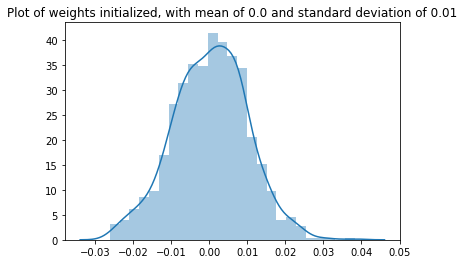

In [11]:
# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

In [12]:
def initialize_bias(shape, name=None, dtype=float):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

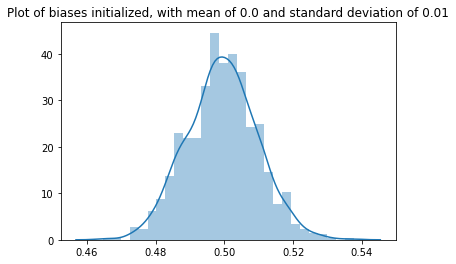

In [13]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [14]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [15]:
model = get_siamese_model((105, 105, 1))
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]        

### Optimizing function and loss function
The training was initially done using Stochastic gradient descent(as described in the paper) with a learning rate 0.0005(choosen randomly between 0.01 and 0.00001) initially, due to which the convergence of model was very slow, after 3000 iterations the validation decreased from .47 to .43, where when the training was done using Adam's algorithm to optimize the training process even though with a smaller learning rate of 0.00006, the decrease in the validation loss was much faster as compared to simple Stochastic Gradient Descent.



In [16]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Image Verification and Recognition



<img src="https://image.ibb.co/k3P0hJ/pixel_comparison.png" style="width:380px;height:150px;"></img>
<caption><center> <u> <font color='black'> **Figure 4**</font> </u></center></caption>
    
    





<img src="https://cdn-images-1.medium.com/max/800/1*wh1N-kogDMaZYS17lqyqeQ.jpeg"></img>
<caption><center> <u> <font color='black'> **Figure 5**</font> </u></center></caption>

## Dataset

<img src="https://cdn-images-1.medium.com/max/1600/1*fRd4Sc6cT0_KFm6IhB3Bqw.png"></img>
<caption><center> <u> <font color='black'> **Figure 6**</font> </u></center></caption>

To demonstrate one shot learning, [Omniglot dataset](https://github.com/brendenlake/omniglot) is used, Omniglot of Lake et al. is a MNIST-like scribbles dataset with 1623 characters with 20 examples each. The large number of classes (characters) with relatively few data per class (20), makes this an ideal data set for testing few-shot classification.

The figures below show few of the samples from the dataset.

In [17]:
def plot_images(path):
    """
        Plot all 20 samples of a particular character of a language
    """
    f, axarr = plt.subplots(5,4, figsize=(10,10))
    images_list = []
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        images_list.append(img)
    for i in range(5):
        for j in range(4):
            axarr[i,j].imshow(images_list.pop())

Arcadian language, 20 samples of the third character.


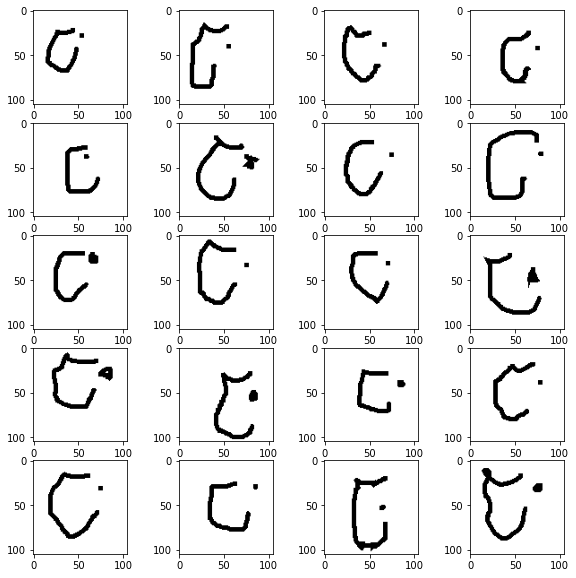

In [18]:
plot_images(os.path.join(data_path, 'images_background/Arcadian/character03/'))
print("Arcadian language, 20 samples of the third character.")

Korean language, 20 samples of the seventh character.


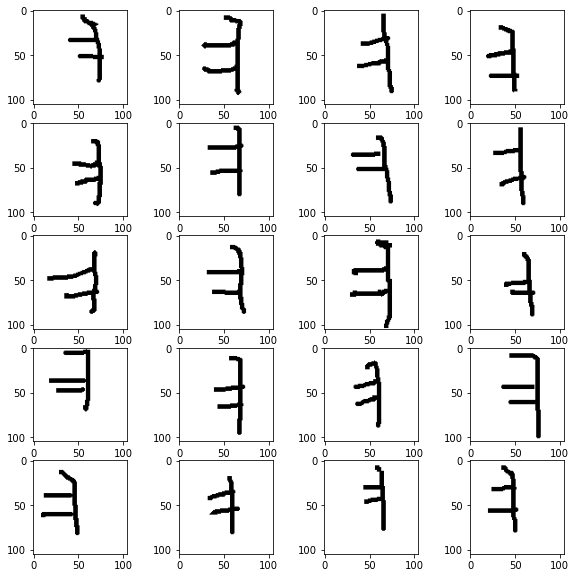

In [19]:
plot_images(os.path.join(data_path, 'images_background/Korean/character07/'))
print("Korean language, 20 samples of the seventh character.")

In [20]:
from load_data import *

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh
loa

In [21]:
with open(os.path.join(data_path, "train.pickle"), "rb") as f:
    (X, classes) = pickle.load(f)

with open(os.path.join(data_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(classes.keys()))
print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Training alphabets: 

['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']
Validation alphabets:

['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


### Training pipeline

In [22]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))
    

loader = Siamese_Loader(data_path)

loading data from data/train.pickle
loading data from data/val.pickle


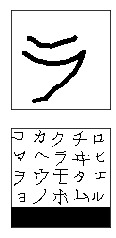

In [23]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)

<font color=red> This training process only take the best validation accuracy model throughout the whole training.
   
Observation: we did try training on both CPU and GPU. The estimated time on CPU was about 2 days while it was only several hours on GPU.

In [24]:
weights_path_2 = os.path.join(data_path, "model_weights.h5")
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path_2))
            model.save_weights(weights_path_2)
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

t_end = time.time()
print('time: ',t_end-t_start)  

model.load_weights(weights_path_2)

Starting training process!
-------------------------------------


 ------------- 

Loss: 4.511821746826172

 ------------- 

Loss: 4.4663004875183105

 ------------- 

Loss: 4.443178176879883

 ------------- 

Loss: 4.395510196685791

 ------------- 

Loss: 4.4015021324157715

 ------------- 

Loss: 4.379580974578857

 ------------- 

Loss: 4.380833148956299

 ------------- 

Loss: 4.326669692993164

 ------------- 

Loss: 4.328747272491455

 ------------- 

Loss: 4.287248611450195
Time for 10 iterations: 20.861361265182495
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 30.0% 20 way one-shot learning accuracy 

Current best: 30.0, previous best: -1
Saving weights to: data/model_weights.h5 


 ------------- 

Loss: 4.300592422485352

 ------------- 

Loss: 4.248208522796631

 ------------- 

Loss: 4.248429298400879

 ------------- 

Loss: 4.198716640472412

 ------------- 

Loss: 4.171845436096191

 ------------- 

Loss: 4.170085906982422

 ------

Got an average of 34.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 2.8149404525756836

 ------------- 

Loss: 2.8337090015411377

 ------------- 

Loss: 2.7514054775238037

 ------------- 

Loss: 2.7166268825531006

 ------------- 

Loss: 2.7076408863067627

 ------------- 

Loss: 2.7531185150146484

 ------------- 

Loss: 2.746304512023926

 ------------- 

Loss: 2.6816670894622803

 ------------- 

Loss: 2.8174147605895996

 ------------- 

Loss: 2.7917168140411377
Time for 140 iterations: 148.75042128562927
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 30.8% 20 way one-shot learning accuracy 

iteration 140, training loss: 2.79,

 ------------- 

Loss: 2.6452789306640625

 ------------- 

Loss: 2.6404635906219482

 ------------- 

Loss: 2.857968807220459

 ------------- 

Loss: 2.760397434234619

 ------------- 

Loss: 2.7132201194763184

 ------------- 

Loss: 2.686095952987671

 ------------- 

Loss: 2.7032625675201416

 ---


 ------------- 

Loss: 2.296497344970703

 ------------- 

Loss: 2.1305992603302

 ------------- 

Loss: 2.139138698577881

 ------------- 

Loss: 2.0749449729919434

 ------------- 

Loss: 2.3694629669189453

 ------------- 

Loss: 2.1405789852142334

 ------------- 

Loss: 2.3384623527526855

 ------------- 

Loss: 1.9819495677947998

 ------------- 

Loss: 2.201040506362915
Time for 270 iterations: 272.2159216403961
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 30.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 2.0027379989624023

 ------------- 

Loss: 2.2895121574401855

 ------------- 

Loss: 2.0248756408691406

 ------------- 

Loss: 1.9235342741012573

 ------------- 

Loss: 2.0358541011810303

 ------------- 

Loss: 2.0838663578033447

 ------------- 

Loss: 2.0527443885803223

 ------------- 

Loss: 2.0596072673797607

 ------------- 

Loss: 2.2414097785949707

 ------------- 

Loss: 2.0784857273101807
Time for 280 itera


 ------------- 

Loss: 1.7237427234649658

 ------------- 

Loss: 1.8050644397735596

 ------------- 

Loss: 1.8811771869659424

 ------------- 

Loss: 1.8983880281448364

 ------------- 

Loss: 1.6503963470458984

 ------------- 

Loss: 1.7293773889541626

 ------------- 

Loss: 1.6447900533676147
Time for 400 iterations: 395.94072246551514
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 42.4% 20 way one-shot learning accuracy 

Current best: 42.4, previous best: 40.0
Saving weights to: data/model_weights.h5 

iteration 400, training loss: 1.64,

 ------------- 

Loss: 1.8894609212875366

 ------------- 

Loss: 1.7293086051940918

 ------------- 

Loss: 1.7405564785003662

 ------------- 

Loss: 1.760304570198059

 ------------- 

Loss: 1.6308348178863525

 ------------- 

Loss: 1.7330166101455688

 ------------- 

Loss: 1.796067476272583

 ------------- 

Loss: 1.8135405778884888

 ------------- 

Loss: 1.8137619495391846

 ------------- 

Loss:


 ------------- 

Loss: 1.4910389184951782

 ------------- 

Loss: 1.3792904615402222

 ------------- 

Loss: 1.417534351348877

 ------------- 

Loss: 1.335971713066101

 ------------- 

Loss: 1.6385159492492676

 ------------- 

Loss: 1.4401586055755615

 ------------- 

Loss: 1.5789997577667236

 ------------- 

Loss: 1.6236119270324707

 ------------- 

Loss: 1.4888279438018799
Time for 530 iterations: 520.5644993782043
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 39.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 1.4173414707183838

 ------------- 

Loss: 1.725820779800415

 ------------- 

Loss: 1.5580737590789795

 ------------- 

Loss: 1.4647042751312256

 ------------- 

Loss: 1.5700997114181519

 ------------- 

Loss: 1.6013262271881104

 ------------- 

Loss: 1.4201350212097168

 ------------- 

Loss: 1.4751646518707275

 ------------- 

Loss: 1.3754578828811646

 ------------- 

Loss: 1.5150960683822632
Time for 540 it


Loss: 1.2570688724517822

 ------------- 

Loss: 1.3029769659042358

 ------------- 

Loss: 1.3029766082763672

 ------------- 

Loss: 1.3765308856964111

 ------------- 

Loss: 1.4544721841812134

 ------------- 

Loss: 1.2864774465560913

 ------------- 

Loss: 1.3428235054016113

 ------------- 

Loss: 1.2056827545166016
Time for 660 iterations: 642.5101308822632
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 54.8% 20 way one-shot learning accuracy 

Current best: 54.8, previous best: 54.4
Saving weights to: data/model_weights.h5 

iteration 660, training loss: 1.21,

 ------------- 

Loss: 1.2081201076507568

 ------------- 

Loss: 1.2569983005523682

 ------------- 

Loss: 1.1625128984451294

 ------------- 

Loss: 1.2806750535964966

 ------------- 

Loss: 1.3594101667404175

 ------------- 

Loss: 1.2305899858474731

 ------------- 

Loss: 1.2043918371200562

 ------------- 

Loss: 1.3711451292037964

 ------------- 

Loss: 1.2864931821823


 ------------- 

Loss: 1.0733468532562256

 ------------- 

Loss: 1.2678000926971436

 ------------- 

Loss: 1.2519681453704834

 ------------- 

Loss: 1.1948938369750977

 ------------- 

Loss: 1.3233094215393066

 ------------- 

Loss: 1.1832001209259033

 ------------- 

Loss: 1.278015375137329

 ------------- 

Loss: 1.1917040348052979

 ------------- 

Loss: 1.1688748598098755

 ------------- 

Loss: 1.1945180892944336
Time for 790 iterations: 764.9204273223877
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 55.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 1.0666261911392212

 ------------- 

Loss: 1.3370766639709473

 ------------- 

Loss: 1.1923537254333496

 ------------- 

Loss: 1.225022315979004

 ------------- 

Loss: 1.1290497779846191

 ------------- 

Loss: 1.2157150506973267

 ------------- 

Loss: 1.1770050525665283

 ------------- 

Loss: 1.28433358669281

 ------------- 

Loss: 1.2059754133224487

 ------------- 


 ------------- 

Loss: 1.1762571334838867

 ------------- 

Loss: 0.9927908182144165

 ------------- 

Loss: 1.0825309753417969

 ------------- 

Loss: 1.106980800628662

 ------------- 

Loss: 1.224346399307251

 ------------- 

Loss: 1.094492793083191

 ------------- 

Loss: 1.1114161014556885
Time for 920 iterations: 889.4746108055115
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 55.6% 20 way one-shot learning accuracy 

iteration 920, training loss: 1.11,

 ------------- 

Loss: 1.108294129371643

 ------------- 

Loss: 1.0316267013549805

 ------------- 

Loss: 1.0856122970581055

 ------------- 

Loss: 1.1083080768585205

 ------------- 

Loss: 0.9846701622009277

 ------------- 

Loss: 1.1518546342849731

 ------------- 

Loss: 1.050291657447815

 ------------- 

Loss: 1.1542792320251465

 ------------- 

Loss: 1.0168653726577759

 ------------- 

Loss: 0.9916080832481384
Time for 930 iterations: 900.0178718566895
Evaluating model on 250 


 ------------- 

Loss: 1.020496129989624

 ------------- 

Loss: 0.9545307159423828
Time for 1050 iterations: 1017.0185132026672
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 56.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.9511135816574097

 ------------- 

Loss: 1.064227819442749

 ------------- 

Loss: 1.0168232917785645

 ------------- 

Loss: 0.9411965012550354

 ------------- 

Loss: 0.9428721070289612

 ------------- 

Loss: 0.8988375067710876

 ------------- 

Loss: 0.986445426940918

 ------------- 

Loss: 1.1185364723205566

 ------------- 

Loss: 0.8974353075027466

 ------------- 

Loss: 0.8890911340713501
Time for 1060 iterations: 1027.0488758087158
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 63.6% 20 way one-shot learning accuracy 

Current best: 63.6, previous best: 62.4
Saving weights to: data/model_weights.h5 

iteration 1060, training loss: 0.89,

 ------------- 

Los


 ------------- 

Loss: 0.8614016771316528
Time for 1180 iterations: 1145.6964883804321
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 57.6% 20 way one-shot learning accuracy 

iteration 1180, training loss: 0.86,

 ------------- 

Loss: 1.0002248287200928

 ------------- 

Loss: 0.8677155375480652

 ------------- 

Loss: 0.9743821620941162

 ------------- 

Loss: 0.9534358978271484

 ------------- 

Loss: 0.9173424243927002

 ------------- 

Loss: 0.881322979927063

 ------------- 

Loss: 0.7760959267616272

 ------------- 

Loss: 1.0088119506835938

 ------------- 

Loss: 0.924282968044281

 ------------- 

Loss: 0.8174688220024109
Time for 1190 iterations: 1155.1720576286316
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 54.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.8625030517578125

 ------------- 

Loss: 1.0903376340866089

 ------------- 

Loss: 0.9966520071029663

 ------------- 


Got an average of 64.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.8095003962516785

 ------------- 

Loss: 0.8263657689094543

 ------------- 

Loss: 0.8325465321540833

 ------------- 

Loss: 0.930600106716156

 ------------- 

Loss: 0.8189873695373535

 ------------- 

Loss: 0.9357317686080933

 ------------- 

Loss: 0.8119457960128784

 ------------- 

Loss: 0.8150454163551331

 ------------- 

Loss: 0.8451502919197083

 ------------- 

Loss: 1.0121710300445557
Time for 1320 iterations: 1280.519657611847
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 52.8% 20 way one-shot learning accuracy 

iteration 1320, training loss: 1.01,

 ------------- 

Loss: 0.8388591408729553

 ------------- 

Loss: 0.8666630983352661

 ------------- 

Loss: 0.9656057357788086

 ------------- 

Loss: 0.7703129053115845

 ------------- 

Loss: 0.7695059180259705

 ------------- 

Loss: 0.8138182163238525

 ------------- 

Loss: 0.9107764959335327




Loss: 0.7578325271606445

 ------------- 

Loss: 0.7662533521652222

 ------------- 

Loss: 0.7216171622276306

 ------------- 

Loss: 0.7067851424217224

 ------------- 

Loss: 0.8416445255279541

 ------------- 

Loss: 0.8595906496047974

 ------------- 

Loss: 0.8103183507919312

 ------------- 

Loss: 0.8733888268470764

 ------------- 

Loss: 0.8397107124328613

 ------------- 

Loss: 0.7889517545700073
Time for 1450 iterations: 1411.8986575603485
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 58.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.7835791707038879

 ------------- 

Loss: 0.7297294735908508

 ------------- 

Loss: 0.8315064907073975

 ------------- 

Loss: 0.7821253538131714

 ------------- 

Loss: 1.1623342037200928

 ------------- 

Loss: 0.7118670344352722

 ------------- 

Loss: 0.7815326452255249

 ------------- 

Loss: 1.0297644138336182

 ------------- 

Loss: 0.831071138381958

 ------------- 

Loss: 0.76


 ------------- 

Loss: 0.7541527152061462

 ------------- 

Loss: 0.9322903156280518

 ------------- 

Loss: 0.6831184029579163

 ------------- 

Loss: 0.7171990275382996

 ------------- 

Loss: 0.8142604827880859

 ------------- 

Loss: 0.8242243528366089

 ------------- 

Loss: 0.6892548203468323

 ------------- 

Loss: 0.7559086680412292
Time for 1580 iterations: 1532.330867767334
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 58.8% 20 way one-shot learning accuracy 

iteration 1580, training loss: 0.76,

 ------------- 

Loss: 0.8017567992210388

 ------------- 

Loss: 0.7719429731369019

 ------------- 

Loss: 0.6940301656723022

 ------------- 

Loss: 0.7733903527259827

 ------------- 

Loss: 0.7121157646179199

 ------------- 

Loss: 0.8019717335700989

 ------------- 

Loss: 0.7426939606666565

 ------------- 

Loss: 0.7879958748817444

 ------------- 

Loss: 0.8081244230270386

 ------------- 

Loss: 0.9877216219902039
Time for 1590 ite


 ------------- 

Loss: 0.7286909818649292

 ------------- 

Loss: 0.825520396232605

 ------------- 

Loss: 0.7771865129470825

 ------------- 

Loss: 0.7195501327514648

 ------------- 

Loss: 0.7975444793701172

 ------------- 

Loss: 0.6515658497810364

 ------------- 

Loss: 0.6573653221130371
Time for 1710 iterations: 1650.3571679592133
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.7740586996078491

 ------------- 

Loss: 0.5772793889045715

 ------------- 

Loss: 0.5893523097038269

 ------------- 

Loss: 0.6739948987960815

 ------------- 

Loss: 0.8174811601638794

 ------------- 

Loss: 0.7385939955711365

 ------------- 

Loss: 0.6940743327140808

 ------------- 

Loss: 0.6226763725280762

 ------------- 

Loss: 0.8377631902694702

 ------------- 

Loss: 0.8682804107666016
Time for 1720 iterations: 1659.4197788238525
Evaluating model on 250 random 20 way one-shot learn


 ------------- 

Loss: 0.6674128174781799

 ------------- 

Loss: 0.6815738677978516

 ------------- 

Loss: 0.6272138357162476

 ------------- 

Loss: 0.7138710021972656

 ------------- 

Loss: 0.7053989171981812
Time for 1840 iterations: 1770.5787465572357
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.4% 20 way one-shot learning accuracy 

iteration 1840, training loss: 0.71,

 ------------- 

Loss: 0.7315995097160339

 ------------- 

Loss: 0.6756367087364197

 ------------- 

Loss: 0.6916822195053101

 ------------- 

Loss: 0.6934017539024353

 ------------- 

Loss: 0.6682177186012268

 ------------- 

Loss: 0.7778195738792419

 ------------- 

Loss: 0.7927384376525879

 ------------- 

Loss: 0.5413237810134888

 ------------- 

Loss: 0.6141234636306763

 ------------- 

Loss: 0.7013891935348511
Time for 1850 iterations: 1779.7820484638214
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.8% 20 way o


 ------------- 

Loss: 0.759960412979126
Time for 1970 iterations: 1891.1365005970001
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.6167711615562439

 ------------- 

Loss: 0.7363789081573486

 ------------- 

Loss: 0.744519829750061

 ------------- 

Loss: 0.6045032739639282

 ------------- 

Loss: 0.6646321415901184

 ------------- 

Loss: 0.6817362904548645

 ------------- 

Loss: 0.643468976020813

 ------------- 

Loss: 0.6828548908233643

 ------------- 

Loss: 0.6654295921325684

 ------------- 

Loss: 0.5871875882148743
Time for 1980 iterations: 1900.4717049598694
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.8% 20 way one-shot learning accuracy 

iteration 1980, training loss: 0.59,

 ------------- 

Loss: 0.650942325592041

 ------------- 

Loss: 0.5477994084358215

 ------------- 

Loss: 0.6636427044868469

 ------------- 

L

Got an average of 70.0% 20 way one-shot learning accuracy 

iteration 2100, training loss: 0.71,

 ------------- 

Loss: 0.6500715017318726

 ------------- 

Loss: 0.734819769859314

 ------------- 

Loss: 0.6727670431137085

 ------------- 

Loss: 0.6329375505447388

 ------------- 

Loss: 0.5718533992767334

 ------------- 

Loss: 0.6573140025138855

 ------------- 

Loss: 0.6490414142608643

 ------------- 

Loss: 0.5884307622909546

 ------------- 

Loss: 0.5391824841499329

 ------------- 

Loss: 0.5133848786354065
Time for 2110 iterations: 2022.9260773658752
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.5570178031921387

 ------------- 

Loss: 0.7122730612754822

 ------------- 

Loss: 0.5695673823356628

 ------------- 

Loss: 0.6741534471511841

 ------------- 

Loss: 0.6022135615348816

 ------------- 

Loss: 0.6244314312934875

 ------------- 

Loss: 0.5196945667266846



 ------------- 

Loss: 0.6260736584663391

 ------------- 

Loss: 0.49468231201171875

 ------------- 

Loss: 0.6237749457359314

 ------------- 

Loss: 0.6467500925064087

 ------------- 

Loss: 0.5104655623435974

 ------------- 

Loss: 0.47619548439979553

 ------------- 

Loss: 0.6102182269096375

 ------------- 

Loss: 0.5545495748519897

 ------------- 

Loss: 0.5376368165016174
Time for 2240 iterations: 2144.4988543987274
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.4% 20 way one-shot learning accuracy 

iteration 2240, training loss: 0.54,

 ------------- 

Loss: 0.6058500409126282

 ------------- 

Loss: 0.6094374656677246

 ------------- 

Loss: 0.549099326133728

 ------------- 

Loss: 0.5927008390426636

 ------------- 

Loss: 0.5609776973724365

 ------------- 

Loss: 0.5697886943817139

 ------------- 

Loss: 0.5362383127212524

 ------------- 

Loss: 0.5027857422828674

 ------------- 

Loss: 0.5730296969413757

 -------------


 ------------- 

Loss: 0.5098322033882141

 ------------- 

Loss: 0.5299724340438843

 ------------- 

Loss: 0.6266832947731018

 ------------- 

Loss: 0.591385006904602

 ------------- 

Loss: 0.5167900919914246

 ------------- 

Loss: 0.5315559506416321
Time for 2370 iterations: 2267.2879164218903
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.6021921634674072

 ------------- 

Loss: 0.5261147618293762

 ------------- 

Loss: 0.5222147703170776

 ------------- 

Loss: 0.5683589577674866

 ------------- 

Loss: 0.47822681069374084

 ------------- 

Loss: 0.46979159116744995

 ------------- 

Loss: 0.5644055008888245

 ------------- 

Loss: 0.6178007125854492

 ------------- 

Loss: 0.6784685850143433

 ------------- 

Loss: 0.6252460479736328
Time for 2380 iterations: 2276.74258184433
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.0% 20 


 ------------- 

Loss: 0.7004466652870178

 ------------- 

Loss: 0.5138399004936218

 ------------- 

Loss: 0.6278047561645508

 ------------- 

Loss: 0.47233515977859497
Time for 2500 iterations: 2390.415243625641
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 67.6% 20 way one-shot learning accuracy 

iteration 2500, training loss: 0.47,

 ------------- 

Loss: 0.5116592645645142

 ------------- 

Loss: 0.6765319108963013

 ------------- 

Loss: 0.49470746517181396

 ------------- 

Loss: 0.47706663608551025

 ------------- 

Loss: 0.5064129829406738

 ------------- 

Loss: 0.48658764362335205

 ------------- 

Loss: 0.5296448469161987

 ------------- 

Loss: 0.609717607498169

 ------------- 

Loss: 0.4747684597969055

 ------------- 

Loss: 0.488084614276886
Time for 2510 iterations: 2399.877990961075
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 67.2% 20 way one-shot learning accuracy 


 -------------


 ------------- 

Loss: 0.5379966497421265
Time for 2630 iterations: 2513.3091428279877
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 67.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.522605299949646

 ------------- 

Loss: 0.5732381343841553

 ------------- 

Loss: 0.45955806970596313

 ------------- 

Loss: 0.5791921615600586

 ------------- 

Loss: 0.5511111617088318

 ------------- 

Loss: 0.5613925457000732

 ------------- 

Loss: 0.6468883752822876

 ------------- 

Loss: 0.5671558976173401

 ------------- 

Loss: 0.5249432921409607

 ------------- 

Loss: 0.5448063611984253
Time for 2640 iterations: 2522.738842725754
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 way one-shot learning accuracy 

iteration 2640, training loss: 0.54,

 ------------- 

Loss: 0.606428861618042

 ------------- 

Loss: 0.4927387535572052

 ------------- 

Loss: 0.4546050429344177

 ------------- 


Got an average of 74.0% 20 way one-shot learning accuracy 

Current best: 74.0, previous best: 74.0
Saving weights to: data/model_weights.h5 

iteration 2760, training loss: 0.45,

 ------------- 

Loss: 0.4778805375099182

 ------------- 

Loss: 0.44247591495513916

 ------------- 

Loss: 0.6184401512145996

 ------------- 

Loss: 0.44811829924583435

 ------------- 

Loss: 0.5527241826057434

 ------------- 

Loss: 0.6449118852615356

 ------------- 

Loss: 0.5833661556243896

 ------------- 

Loss: 0.4992145299911499

 ------------- 

Loss: 0.46671104431152344

 ------------- 

Loss: 0.508009672164917
Time for 2770 iterations: 2646.214310646057
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.5302712321281433

 ------------- 

Loss: 0.6218662261962891

 ------------- 

Loss: 0.4706399440765381

 ------------- 

Loss: 0.5158002376556396

 ------------- 

Loss: 0.49428731203079224


Got an average of 70.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.43241673707962036

 ------------- 

Loss: 0.43616676330566406

 ------------- 

Loss: 0.4518105387687683

 ------------- 

Loss: 0.46382007002830505

 ------------- 

Loss: 0.42830389738082886

 ------------- 

Loss: 0.4353850483894348

 ------------- 

Loss: 0.454782634973526

 ------------- 

Loss: 0.40181154012680054

 ------------- 

Loss: 0.43688827753067017

 ------------- 

Loss: 0.4008987247943878
Time for 2900 iterations: 2770.564966440201
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 62.8% 20 way one-shot learning accuracy 

iteration 2900, training loss: 0.40,

 ------------- 

Loss: 0.40868422389030457

 ------------- 

Loss: 0.4377341568470001

 ------------- 

Loss: 0.4937194585800171

 ------------- 

Loss: 0.6443674564361572

 ------------- 

Loss: 0.4441191852092743

 ------------- 

Loss: 0.5215954184532166

 ------------- 

Loss: 0.40244099497


 ------------- 

Loss: 0.4240891933441162

 ------------- 

Loss: 0.44922006130218506

 ------------- 

Loss: 0.4769876301288605

 ------------- 

Loss: 0.5517773628234863

 ------------- 

Loss: 0.5341786742210388

 ------------- 

Loss: 0.48087799549102783

 ------------- 

Loss: 0.4001471698284149

 ------------- 

Loss: 0.4260522425174713

 ------------- 

Loss: 0.4017220139503479

 ------------- 

Loss: 0.39369940757751465
Time for 3030 iterations: 2893.595618247986
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.4897691607475281

 ------------- 

Loss: 0.5042189359664917

 ------------- 

Loss: 0.398162841796875

 ------------- 

Loss: 0.45828741788864136

 ------------- 

Loss: 0.48393452167510986

 ------------- 

Loss: 0.43805813789367676

 ------------- 

Loss: 0.4313952624797821

 ------------- 

Loss: 0.6382397413253784

 ------------- 

Loss: 0.5967060923576355

 ----


 ------------- 

Loss: 0.5378703474998474

 ------------- 

Loss: 0.576535165309906

 ------------- 

Loss: 0.3929986357688904

 ------------- 

Loss: 0.47949546575546265

 ------------- 

Loss: 0.5503524541854858

 ------------- 

Loss: 0.3747680187225342

 ------------- 

Loss: 0.7678782343864441
Time for 3160 iterations: 3016.42262840271
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 

iteration 3160, training loss: 0.77,

 ------------- 

Loss: 0.6369436979293823

 ------------- 

Loss: 0.4000346064567566

 ------------- 

Loss: 0.3949120044708252

 ------------- 

Loss: 0.47544345259666443

 ------------- 

Loss: 0.5138505101203918

 ------------- 

Loss: 0.4450796842575073

 ------------- 

Loss: 0.4413977563381195

 ------------- 

Loss: 0.4354463219642639

 ------------- 

Loss: 0.41297125816345215

 ------------- 

Loss: 0.4023049473762512
Time for 3170 iterations: 3025.879722595215
Evaluating mode


 ------------- 

Loss: 0.4757533669471741

 ------------- 

Loss: 0.48983025550842285

 ------------- 

Loss: 0.4686790704727173

 ------------- 

Loss: 0.43830668926239014

 ------------- 

Loss: 0.41915392875671387

 ------------- 

Loss: 0.4018964469432831
Time for 3290 iterations: 3139.4614930152893
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.4296257495880127

 ------------- 

Loss: 0.42895978689193726

 ------------- 

Loss: 0.37574973702430725

 ------------- 

Loss: 0.39179715514183044

 ------------- 

Loss: 0.3945501148700714

 ------------- 

Loss: 0.40466928482055664

 ------------- 

Loss: 0.49096906185150146

 ------------- 

Loss: 0.4061968922615051

 ------------- 

Loss: 0.4609537124633789

 ------------- 

Loss: 0.5480572581291199
Time for 3300 iterations: 3148.884260416031
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 6


 ------------- 

Loss: 0.44240522384643555

 ------------- 

Loss: 0.40864288806915283

 ------------- 

Loss: 0.47735753655433655

 ------------- 

Loss: 0.339228093624115

 ------------- 

Loss: 0.36546075344085693
Time for 3420 iterations: 3262.4599430561066
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 59.2% 20 way one-shot learning accuracy 

iteration 3420, training loss: 0.37,

 ------------- 

Loss: 0.3549904227256775

 ------------- 

Loss: 0.4531479775905609

 ------------- 

Loss: 0.3618907630443573

 ------------- 

Loss: 0.39201685786247253

 ------------- 

Loss: 0.3833780288696289

 ------------- 

Loss: 0.5028711557388306

 ------------- 

Loss: 0.4855371117591858

 ------------- 

Loss: 0.34273672103881836

 ------------- 

Loss: 0.49944108724594116

 ------------- 

Loss: 0.3779483437538147
Time for 3430 iterations: 3271.9175431728363
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.2% 20


 ------------- 

Loss: 0.4349280595779419

 ------------- 

Loss: 0.49642738699913025

 ------------- 

Loss: 0.5277917385101318
Time for 3550 iterations: 3385.273169517517
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.36297446489334106

 ------------- 

Loss: 0.3381189703941345

 ------------- 

Loss: 0.4026185870170593

 ------------- 

Loss: 0.5596814155578613

 ------------- 

Loss: 0.49907541275024414

 ------------- 

Loss: 0.41568854451179504

 ------------- 

Loss: 0.4197826087474823

 ------------- 

Loss: 0.3971792459487915

 ------------- 

Loss: 0.47158294916152954

 ------------- 

Loss: 0.44358187913894653
Time for 3560 iterations: 3394.712892770767
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 

iteration 3560, training loss: 0.44,

 ------------- 

Loss: 0.43325257301330566

 --------

Got an average of 71.2% 20 way one-shot learning accuracy 

iteration 3680, training loss: 0.53,

 ------------- 

Loss: 0.4444151818752289

 ------------- 

Loss: 0.3757057785987854

 ------------- 

Loss: 0.33048832416534424

 ------------- 

Loss: 0.4146483540534973

 ------------- 

Loss: 0.4194512963294983

 ------------- 

Loss: 0.3942856192588806

 ------------- 

Loss: 0.46069929003715515

 ------------- 

Loss: 0.3776070475578308

 ------------- 

Loss: 0.39181530475616455

 ------------- 

Loss: 0.4266154170036316
Time for 3690 iterations: 3517.479597568512
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.379763662815094

 ------------- 

Loss: 0.47155672311782837

 ------------- 

Loss: 0.3414405882358551

 ------------- 

Loss: 0.3719148635864258

 ------------- 

Loss: 0.3390149176120758

 ------------- 

Loss: 0.34928077459335327

 ------------- 

Loss: 0.4114090204238


 ------------- 

Loss: 0.34788691997528076

 ------------- 

Loss: 0.4303233027458191

 ------------- 

Loss: 0.45354902744293213

 ------------- 

Loss: 0.4493330419063568

 ------------- 

Loss: 0.36030834913253784

 ------------- 

Loss: 0.40312954783439636

 ------------- 

Loss: 0.3778950870037079

 ------------- 

Loss: 0.40793585777282715
Time for 3820 iterations: 3641.653478860855
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 

iteration 3820, training loss: 0.41,

 ------------- 

Loss: 0.42973792552948

 ------------- 

Loss: 0.36082351207733154

 ------------- 

Loss: 0.6361365914344788

 ------------- 

Loss: 0.4113544821739197

 ------------- 

Loss: 0.37263762950897217

 ------------- 

Loss: 0.38530683517456055

 ------------- 

Loss: 0.36970484256744385

 ------------- 

Loss: 0.3787249028682709

 ------------- 

Loss: 0.4467529058456421

 ------------- 

Loss: 0.2998655140399933
Time for 3


 ------------- 

Loss: 0.46079298853874207

 ------------- 

Loss: 0.5711511373519897

 ------------- 

Loss: 0.4044932723045349

 ------------- 

Loss: 0.37588930130004883

 ------------- 

Loss: 0.4347648024559021

 ------------- 

Loss: 0.4345781207084656

 ------------- 

Loss: 0.4001873731613159
Time for 3950 iterations: 3764.1910033226013
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.35010072588920593

 ------------- 

Loss: 0.41070371866226196

 ------------- 

Loss: 0.3726959228515625

 ------------- 

Loss: 0.41955238580703735

 ------------- 

Loss: 0.31370723247528076

 ------------- 

Loss: 0.2963612675666809

 ------------- 

Loss: 0.3441808223724365

 ------------- 

Loss: 0.3295908570289612

 ------------- 

Loss: 0.2938253879547119

 ------------- 

Loss: 0.3511287569999695
Time for 3960 iterations: 3773.4353778362274
Evaluating model on 250 random 20 way one-sho


 ------------- 

Loss: 0.4981958270072937

 ------------- 

Loss: 0.4449763894081116

 ------------- 

Loss: 0.6213008761405945
Time for 4080 iterations: 3882.1198811531067
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.8% 20 way one-shot learning accuracy 

iteration 4080, training loss: 0.62,

 ------------- 

Loss: 0.3355693817138672

 ------------- 

Loss: 0.44375085830688477

 ------------- 

Loss: 0.36451300978660583

 ------------- 

Loss: 0.5505178570747375

 ------------- 

Loss: 0.3611902594566345

 ------------- 

Loss: 0.4332816004753113

 ------------- 

Loss: 0.34627315402030945

 ------------- 

Loss: 0.38854342699050903

 ------------- 

Loss: 0.37493687868118286

 ------------- 

Loss: 0.378274142742157
Time for 4090 iterations: 3891.189512729645
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3669790029525757

 ----------


 ------------- 

Loss: 0.3542611598968506

 ------------- 

Loss: 0.5301981568336487
Time for 4210 iterations: 4000.0794258117676
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3513975143432617

 ------------- 

Loss: 0.37794214487075806

 ------------- 

Loss: 0.4933733642101288

 ------------- 

Loss: 0.33876660466194153

 ------------- 

Loss: 0.3748108744621277

 ------------- 

Loss: 0.5436165928840637

 ------------- 

Loss: 0.3916044235229492

 ------------- 

Loss: 0.37797239422798157

 ------------- 

Loss: 0.4457243084907532

 ------------- 

Loss: 0.316245973110199
Time for 4220 iterations: 4009.1370062828064
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.4% 20 way one-shot learning accuracy 

iteration 4220, training loss: 0.32,

 ------------- 

Loss: 0.33201155066490173

 ------------- 

Loss: 0.3181723952293396

 ----------

Got an average of 72.0% 20 way one-shot learning accuracy 

iteration 4340, training loss: 0.40,

 ------------- 

Loss: 0.3628176152706146

 ------------- 

Loss: 0.37346625328063965

 ------------- 

Loss: 0.41915392875671387

 ------------- 

Loss: 0.33926481008529663

 ------------- 

Loss: 0.290818989276886

 ------------- 

Loss: 0.2997196912765503

 ------------- 

Loss: 0.37491804361343384

 ------------- 

Loss: 0.3491007685661316

 ------------- 

Loss: 0.37930673360824585

 ------------- 

Loss: 0.3010854125022888
Time for 4350 iterations: 4128.432254552841
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3015785813331604

 ------------- 

Loss: 0.27342459559440613

 ------------- 

Loss: 0.3266836106777191

 ------------- 

Loss: 0.4660121202468872

 ------------- 

Loss: 0.3090856075286865

 ------------- 

Loss: 0.3863425850868225

 ------------- 

Loss: 0.361601144075

Got an average of 70.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3277379274368286

 ------------- 

Loss: 0.4436441659927368

 ------------- 

Loss: 0.3459134101867676

 ------------- 

Loss: 0.35877183079719543

 ------------- 

Loss: 0.37144047021865845

 ------------- 

Loss: 0.3896060883998871

 ------------- 

Loss: 0.39253461360931396

 ------------- 

Loss: 0.31865495443344116

 ------------- 

Loss: 0.3948171138763428

 ------------- 

Loss: 0.30303090810775757
Time for 4480 iterations: 4247.869115829468
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.2% 20 way one-shot learning accuracy 

iteration 4480, training loss: 0.30,

 ------------- 

Loss: 0.31364068388938904

 ------------- 

Loss: 0.39944541454315186

 ------------- 

Loss: 0.3437928557395935

 ------------- 

Loss: 0.42370957136154175

 ------------- 

Loss: 0.3609180450439453

 ------------- 

Loss: 0.35027438402175903

 ------------- 

Loss: 0.40825337


 ------------- 

Loss: 0.2753065228462219

 ------------- 

Loss: 0.2811203598976135

 ------------- 

Loss: 0.2775137722492218

 ------------- 

Loss: 0.31238260865211487

 ------------- 

Loss: 0.27334731817245483

 ------------- 

Loss: 0.2969522476196289

 ------------- 

Loss: 0.29733628034591675

 ------------- 

Loss: 0.37136685848236084

 ------------- 

Loss: 0.391485333442688
Time for 4610 iterations: 4367.691607236862
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.33237525820732117

 ------------- 

Loss: 0.27937477827072144

 ------------- 

Loss: 0.35340046882629395

 ------------- 

Loss: 0.422772616147995

 ------------- 

Loss: 0.3582923412322998

 ------------- 

Loss: 0.3361026644706726

 ------------- 

Loss: 0.33216720819473267

 ------------- 

Loss: 0.38356640934944153

 ------------- 

Loss: 0.33205658197402954

 ------------- 

Loss: 0.297186017036438
Time

Loss: 0.38519152998924255

 ------------- 

Loss: 0.29026123881340027

 ------------- 

Loss: 0.3136369287967682

 ------------- 

Loss: 0.29481837153434753

 ------------- 

Loss: 0.3238244652748108

 ------------- 

Loss: 0.33490318059921265
Time for 4740 iterations: 4486.13155913353
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 way one-shot learning accuracy 

iteration 4740, training loss: 0.33,

 ------------- 

Loss: 0.3055872917175293

 ------------- 

Loss: 0.3606031537055969

 ------------- 

Loss: 0.48971301317214966

 ------------- 

Loss: 0.2631993889808655

 ------------- 

Loss: 0.5275381207466125

 ------------- 

Loss: 0.3257845640182495

 ------------- 

Loss: 0.2858596742153168

 ------------- 

Loss: 0.3584827780723572

 ------------- 

Loss: 0.33172523975372314

 ------------- 

Loss: 0.2917247414588928
Time for 4750 iterations: 4495.550823926926
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got 


 ------------- 

Loss: 0.3036751449108124

 ------------- 

Loss: 0.3282307982444763

 ------------- 

Loss: 0.30831003189086914
Time for 4870 iterations: 4604.773644208908
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.29258203506469727

 ------------- 

Loss: 0.2792071998119354

 ------------- 

Loss: 0.29969799518585205

 ------------- 

Loss: 0.42423367500305176

 ------------- 

Loss: 0.4164329767227173

 ------------- 

Loss: 0.3191724419593811

 ------------- 

Loss: 0.2781442701816559

 ------------- 

Loss: 0.28915470838546753

 ------------- 

Loss: 0.28308746218681335

 ------------- 

Loss: 0.32331448793411255
Time for 4880 iterations: 4613.986332893372
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.2% 20 way one-shot learning accuracy 

iteration 4880, training loss: 0.32,

 ------------- 

Loss: 0.6111792922019958

 --------

Got an average of 75.6% 20 way one-shot learning accuracy 

iteration 5000, training loss: 0.29,

 ------------- 

Loss: 0.4692533612251282

 ------------- 

Loss: 0.297810435295105

 ------------- 

Loss: 0.2833385467529297

 ------------- 

Loss: 0.2553721070289612

 ------------- 

Loss: 0.2958700358867645

 ------------- 

Loss: 0.2609078884124756

 ------------- 

Loss: 0.42113959789276123

 ------------- 

Loss: 0.41005241870880127

 ------------- 

Loss: 0.31263938546180725

 ------------- 

Loss: 0.32151517271995544
Time for 5010 iterations: 4735.010772943497
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.36853545904159546

 ------------- 

Loss: 0.3376099467277527

 ------------- 

Loss: 0.5019958019256592

 ------------- 

Loss: 0.34571945667266846

 ------------- 

Loss: 0.41650378704071045

 ------------- 

Loss: 0.37669825553894043

 ------------- 

Loss: 0.3358576297

Got an average of 74.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.326613187789917

 ------------- 

Loss: 0.34781450033187866

 ------------- 

Loss: 0.31559863686561584

 ------------- 

Loss: 0.2862013876438141

 ------------- 

Loss: 0.27953407168388367

 ------------- 

Loss: 0.43837130069732666

 ------------- 

Loss: 0.40070992708206177

 ------------- 

Loss: 0.4467865824699402

 ------------- 

Loss: 0.3126775324344635

 ------------- 

Loss: 0.2870709300041199
Time for 5140 iterations: 4856.524059295654
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 

iteration 5140, training loss: 0.29,

 ------------- 

Loss: 0.30483126640319824

 ------------- 

Loss: 0.3976409435272217

 ------------- 

Loss: 0.25060394406318665

 ------------- 

Loss: 0.3700803518295288

 ------------- 

Loss: 0.7546038627624512

 ------------- 

Loss: 0.3832099437713623

 ------------- 

Loss: 0.30453276634


 ------------- 

Loss: 0.2900015413761139

 ------------- 

Loss: 0.37136825919151306

 ------------- 

Loss: 0.38288575410842896

 ------------- 

Loss: 0.34689486026763916

 ------------- 

Loss: 0.32550886273384094

 ------------- 

Loss: 0.25215187668800354

 ------------- 

Loss: 0.25170719623565674

 ------------- 

Loss: 0.30234605073928833

 ------------- 

Loss: 0.25436335802078247
Time for 5270 iterations: 4979.391979455948
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3560110926628113

 ------------- 

Loss: 0.40270668268203735

 ------------- 

Loss: 0.25394564867019653

 ------------- 

Loss: 0.33056697249412537

 ------------- 

Loss: 0.37565603852272034

 ------------- 

Loss: 0.3599240779876709

 ------------- 

Loss: 0.2500655949115753

 ------------- 

Loss: 0.26929986476898193

 ------------- 

Loss: 0.2487192302942276

 ------------- 

Loss: 0.262595415115356


 ------------- 

Loss: 0.236430361866951

 ------------- 

Loss: 0.5053683519363403

 ------------- 

Loss: 0.3193379044532776

 ------------- 

Loss: 0.2680847942829132

 ------------- 

Loss: 0.32198604941368103

 ------------- 

Loss: 0.29333871603012085
Time for 5400 iterations: 5100.875775575638
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.2% 20 way one-shot learning accuracy 

iteration 5400, training loss: 0.29,

 ------------- 

Loss: 0.30017781257629395

 ------------- 

Loss: 0.4265967607498169

 ------------- 

Loss: 0.2881337106227875

 ------------- 

Loss: 0.44516468048095703

 ------------- 

Loss: 0.25112980604171753

 ------------- 

Loss: 0.3458094596862793

 ------------- 

Loss: 0.28724831342697144

 ------------- 

Loss: 0.36123156547546387

 ------------- 

Loss: 0.31431353092193604

 ------------- 

Loss: 0.3302285075187683
Time for 5410 iterations: 5110.145059585571
Evaluating model on 250 random 20 way one-shot learn


 ------------- 

Loss: 0.3262392282485962

 ------------- 

Loss: 0.2959050238132477

 ------------- 

Loss: 0.3290625810623169

 ------------- 

Loss: 0.26924166083335876

 ------------- 

Loss: 0.32808685302734375
Time for 5530 iterations: 5221.4516859054565
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.30067920684814453

 ------------- 

Loss: 0.266254186630249

 ------------- 

Loss: 0.2507399916648865

 ------------- 

Loss: 0.28315120935440063

 ------------- 

Loss: 0.46544721722602844

 ------------- 

Loss: 0.3307095766067505

 ------------- 

Loss: 0.4726409316062927

 ------------- 

Loss: 0.570078432559967

 ------------- 

Loss: 0.4793044924736023

 ------------- 

Loss: 0.32099440693855286
Time for 5540 iterations: 5230.623863220215
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 

iterat


 ------------- 

Loss: 0.3643333911895752

 ------------- 

Loss: 0.35045725107192993

 ------------- 

Loss: 0.32147860527038574

 ------------- 

Loss: 0.278434157371521

 ------------- 

Loss: 0.2692616581916809
Time for 5660 iterations: 5341.3475794792175
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.0% 20 way one-shot learning accuracy 

iteration 5660, training loss: 0.27,

 ------------- 

Loss: 0.45436936616897583

 ------------- 

Loss: 0.3185020983219147

 ------------- 

Loss: 0.36132851243019104

 ------------- 

Loss: 0.3073376715183258

 ------------- 

Loss: 0.29393628239631653

 ------------- 

Loss: 0.3948102593421936

 ------------- 

Loss: 0.4067804515361786

 ------------- 

Loss: 0.27479392290115356

 ------------- 

Loss: 0.4445650577545166

 ------------- 

Loss: 0.3978680968284607
Time for 5670 iterations: 5350.653221607208
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 w


 ------------- 

Loss: 0.43996578454971313

 ------------- 

Loss: 0.22113487124443054

 ------------- 

Loss: 0.343232125043869
Time for 5790 iterations: 5462.396897792816
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.31777000427246094

 ------------- 

Loss: 0.37588825821876526

 ------------- 

Loss: 0.3484334647655487

 ------------- 

Loss: 0.3540627956390381

 ------------- 

Loss: 0.3561345934867859

 ------------- 

Loss: 0.35935595631599426

 ------------- 

Loss: 0.30451521277427673

 ------------- 

Loss: 0.24163095653057098

 ------------- 

Loss: 0.2671145498752594

 ------------- 

Loss: 0.30752819776535034
Time for 5800 iterations: 5471.51561498642
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 

iteration 5800, training loss: 0.31,

 ------------- 

Loss: 0.21868982911109924

 --------

Got an average of 73.6% 20 way one-shot learning accuracy 

iteration 5920, training loss: 0.36,

 ------------- 

Loss: 0.3106284737586975

 ------------- 

Loss: 0.26085764169692993

 ------------- 

Loss: 0.3327539563179016

 ------------- 

Loss: 0.28323718905448914

 ------------- 

Loss: 0.23576819896697998

 ------------- 

Loss: 0.31012195348739624

 ------------- 

Loss: 0.31026503443717957

 ------------- 

Loss: 0.4047220051288605

 ------------- 

Loss: 0.234303280711174

 ------------- 

Loss: 0.3712891936302185
Time for 5930 iterations: 5592.516569375992
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.31484150886535645

 ------------- 

Loss: 0.37563854455947876

 ------------- 

Loss: 0.3010910153388977

 ------------- 

Loss: 0.26837360858917236

 ------------- 

Loss: 0.42826592922210693

 ------------- 

Loss: 0.3778577148914337

 ------------- 

Loss: 0.258857250

Loss: 0.3733389973640442

 ------------- 

Loss: 0.3864506483078003

 ------------- 

Loss: 0.33245617151260376

 ------------- 

Loss: 0.28769609332084656

 ------------- 

Loss: 0.36309748888015747

 ------------- 

Loss: 0.4120592474937439

 ------------- 

Loss: 0.34198927879333496

 ------------- 

Loss: 0.26948538422584534

 ------------- 

Loss: 0.4752081632614136

 ------------- 

Loss: 0.24270960688591003
Time for 6060 iterations: 5713.311203956604
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.6% 20 way one-shot learning accuracy 

iteration 6060, training loss: 0.24,

 ------------- 

Loss: 0.24628576636314392

 ------------- 

Loss: 0.32160523533821106

 ------------- 

Loss: 0.28398004174232483

 ------------- 

Loss: 0.2607426643371582

 ------------- 

Loss: 0.3185323178768158

 ------------- 

Loss: 0.2496740072965622

 ------------- 

Loss: 0.2504708766937256

 ------------- 

Loss: 0.28829213976860046

 ------------- 

Loss: 0


 ------------- 

Loss: 0.41382747888565063

 ------------- 

Loss: 0.30198636651039124

 ------------- 

Loss: 0.2574663460254669

 ------------- 

Loss: 0.25969749689102173

 ------------- 

Loss: 0.32502496242523193

 ------------- 

Loss: 0.34055596590042114

 ------------- 

Loss: 0.3141213357448578
Time for 6190 iterations: 5834.756667613983
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2334420084953308

 ------------- 

Loss: 0.2467927634716034

 ------------- 

Loss: 0.36197566986083984

 ------------- 

Loss: 0.2932206690311432

 ------------- 

Loss: 0.4187869429588318

 ------------- 

Loss: 0.4717215895652771

 ------------- 

Loss: 0.3202974200248718

 ------------- 

Loss: 0.29809069633483887

 ------------- 

Loss: 0.2986636459827423

 ------------- 

Loss: 0.36937904357910156
Time for 6200 iterations: 5844.053421020508
Evaluating model on 250 random 20 way one-sho


 ------------- 

Loss: 0.4093456268310547

 ------------- 

Loss: 0.3056055009365082

 ------------- 

Loss: 0.3639513850212097

 ------------- 

Loss: 0.2476297914981842

 ------------- 

Loss: 0.3689783811569214
Time for 6320 iterations: 5954.207389593124
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 

iteration 6320, training loss: 0.37,

 ------------- 

Loss: 0.2384796142578125

 ------------- 

Loss: 0.2660677433013916

 ------------- 

Loss: 0.2311895787715912

 ------------- 

Loss: 0.3107626140117645

 ------------- 

Loss: 0.3033393919467926

 ------------- 

Loss: 0.25120386481285095

 ------------- 

Loss: 0.33174505829811096

 ------------- 

Loss: 0.21987798810005188

 ------------- 

Loss: 0.2507844865322113

 ------------- 

Loss: 0.34338927268981934
Time for 6330 iterations: 5964.156854152679
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.8% 20 way


 ------------- 

Loss: 0.42458534240722656

 ------------- 

Loss: 0.29036635160446167
Time for 6450 iterations: 6078.461366653442
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.33565300703048706

 ------------- 

Loss: 0.24287953972816467

 ------------- 

Loss: 0.23012278974056244

 ------------- 

Loss: 0.3368479609489441

 ------------- 

Loss: 0.2846565842628479

 ------------- 

Loss: 0.21103060245513916

 ------------- 

Loss: 0.27238842844963074

 ------------- 

Loss: 0.2886253297328949

 ------------- 

Loss: 0.24769675731658936

 ------------- 

Loss: 0.3621133267879486
Time for 6460 iterations: 6088.521520853043
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 

iteration 6460, training loss: 0.36,

 ------------- 

Loss: 0.29343879222869873

 ------------- 

Loss: 0.2680867612361908

 ------

Got an average of 78.8% 20 way one-shot learning accuracy 

iteration 6580, training loss: 0.27,

 ------------- 

Loss: 0.2516064941883087

 ------------- 

Loss: 0.26087385416030884

 ------------- 

Loss: 0.31469815969467163

 ------------- 

Loss: 0.3476732075214386

 ------------- 

Loss: 0.23702305555343628

 ------------- 

Loss: 0.20179669559001923

 ------------- 

Loss: 0.2521043121814728

 ------------- 

Loss: 0.3517402410507202

 ------------- 

Loss: 0.32250362634658813

 ------------- 

Loss: 0.21233853697776794
Time for 6590 iterations: 6210.077553033829
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.31434494256973267

 ------------- 

Loss: 0.32628658413887024

 ------------- 

Loss: 0.22092361748218536

 ------------- 

Loss: 0.2366274744272232

 ------------- 

Loss: 0.2662104368209839

 ------------- 

Loss: 0.3769034147262573

 ------------- 

Loss: 0.29021951

Got an average of 74.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.22538480162620544

 ------------- 

Loss: 0.26179826259613037

 ------------- 

Loss: 0.3752583861351013

 ------------- 

Loss: 0.2093251347541809

 ------------- 

Loss: 0.22779621183872223

 ------------- 

Loss: 0.31394171714782715

 ------------- 

Loss: 0.37910759449005127

 ------------- 

Loss: 0.24892064929008484

 ------------- 

Loss: 0.26825326681137085

 ------------- 

Loss: 0.27027612924575806
Time for 6720 iterations: 6337.711963653564
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.0% 20 way one-shot learning accuracy 

iteration 6720, training loss: 0.27,

 ------------- 

Loss: 0.2800869345664978

 ------------- 

Loss: 0.32153987884521484

 ------------- 

Loss: 0.23302190005779266

 ------------- 

Loss: 0.3874332308769226

 ------------- 

Loss: 0.4878973066806793

 ------------- 

Loss: 0.25018298625946045

 ------------- 

Loss: 0.257758


 ------------- 

Loss: 0.2783425748348236

 ------------- 

Loss: 0.22312092781066895

 ------------- 

Loss: 0.3824102282524109

 ------------- 

Loss: 0.2286471128463745

 ------------- 

Loss: 0.3515212833881378

 ------------- 

Loss: 0.24421799182891846

 ------------- 

Loss: 0.41674578189849854

 ------------- 

Loss: 0.41435080766677856

 ------------- 

Loss: 0.25390976667404175

 ------------- 

Loss: 0.24310189485549927
Time for 6850 iterations: 6460.542015075684
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

Current best: 80.8, previous best: 80.8
Saving weights to: data/model_weights.h5 


 ------------- 

Loss: 0.27531638741493225

 ------------- 

Loss: 0.2645229697227478

 ------------- 

Loss: 0.30844852328300476

 ------------- 

Loss: 0.4217967987060547

 ------------- 

Loss: 0.3454146683216095

 ------------- 

Loss: 0.2589380145072937

 ------------- 

Loss: 0.2555701732635498

 ----


 ------------- 

Loss: 0.2639438807964325

 ------------- 

Loss: 0.25405460596084595

 ------------- 

Loss: 0.21774910390377045

 ------------- 

Loss: 0.22749042510986328

 ------------- 

Loss: 0.28086113929748535

 ------------- 

Loss: 0.3039463460445404

 ------------- 

Loss: 0.24225586652755737

 ------------- 

Loss: 0.34318307042121887

 ------------- 

Loss: 0.4248078167438507
Time for 6980 iterations: 6588.111031770706
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.8% 20 way one-shot learning accuracy 

iteration 6980, training loss: 0.42,

 ------------- 

Loss: 0.28858131170272827

 ------------- 

Loss: 0.2921302914619446

 ------------- 

Loss: 0.28372302651405334

 ------------- 

Loss: 0.24866889417171478

 ------------- 

Loss: 0.2357116937637329

 ------------- 

Loss: 0.2814299464225769

 ------------- 

Loss: 0.38344043493270874

 ------------- 

Loss: 0.42819464206695557

 ------------- 

Loss: 0.3235763907432556

 ----


 ------------- 

Loss: 0.2390051931142807

 ------------- 

Loss: 0.24768030643463135

 ------------- 

Loss: 0.27566826343536377

 ------------- 

Loss: 0.2745105028152466

 ------------- 

Loss: 0.25574013590812683

 ------------- 

Loss: 0.21497246623039246

 ------------- 

Loss: 0.32040169835090637
Time for 7110 iterations: 6710.427327632904
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.24793867766857147

 ------------- 

Loss: 0.2668718695640564

 ------------- 

Loss: 0.2963172197341919

 ------------- 

Loss: 0.25951117277145386

 ------------- 

Loss: 0.2665935456752777

 ------------- 

Loss: 0.26590296626091003

 ------------- 

Loss: 0.2443145513534546

 ------------- 

Loss: 0.1963421106338501

 ------------- 

Loss: 0.2784575819969177

 ------------- 

Loss: 0.22808268666267395
Time for 7120 iterations: 6719.7636930942535
Evaluating model on 250 random 20 way one-s


 ------------- 

Loss: 0.23665779829025269

 ------------- 

Loss: 0.34539794921875

 ------------- 

Loss: 0.32730334997177124

 ------------- 

Loss: 0.3853490948677063

 ------------- 

Loss: 0.2641189694404602
Time for 7240 iterations: 6832.127873182297
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 

iteration 7240, training loss: 0.26,

 ------------- 

Loss: 0.2376890629529953

 ------------- 

Loss: 0.30895689129829407

 ------------- 

Loss: 0.26879316568374634

 ------------- 

Loss: 0.23774383962154388

 ------------- 

Loss: 0.35790690779685974

 ------------- 

Loss: 0.24466843903064728

 ------------- 

Loss: 0.3708697259426117

 ------------- 

Loss: 0.2205171138048172

 ------------- 

Loss: 0.4399820566177368

 ------------- 

Loss: 0.24599207937717438
Time for 7250 iterations: 6841.400196552277
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 w


 ------------- 

Loss: 0.2624853253364563

 ------------- 

Loss: 0.19358623027801514

 ------------- 

Loss: 0.20592400431632996
Time for 7370 iterations: 6954.54421043396
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2198844701051712

 ------------- 

Loss: 0.19581249356269836

 ------------- 

Loss: 0.367564857006073

 ------------- 

Loss: 0.39717280864715576

 ------------- 

Loss: 0.2188175469636917

 ------------- 

Loss: 0.20860600471496582

 ------------- 

Loss: 0.30589279532432556

 ------------- 

Loss: 0.3171018958091736

 ------------- 

Loss: 0.25011131167411804

 ------------- 

Loss: 0.35956981778144836
Time for 7380 iterations: 6964.130041837692
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 

iteration 7380, training loss: 0.36,

 ------------- 

Loss: 0.24907098710536957

 --------


 ------------- 

Loss: 0.24147681891918182

 ------------- 

Loss: 0.30399829149246216
Time for 7500 iterations: 7081.515247106552
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 7500, training loss: 0.30,

 ------------- 

Loss: 0.28540176153182983

 ------------- 

Loss: 0.19616782665252686

 ------------- 

Loss: 0.2029658406972885

 ------------- 

Loss: 0.27427953481674194

 ------------- 

Loss: 0.256610244512558

 ------------- 

Loss: 0.2990652322769165

 ------------- 

Loss: 0.25510621070861816

 ------------- 

Loss: 0.22856318950653076

 ------------- 

Loss: 0.2635912597179413

 ------------- 

Loss: 0.20474424958229065
Time for 7510 iterations: 7091.049786090851
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2886190414428711

 ------------- 

Loss: 0.3058326840400696

 --------

Got an average of 78.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.20094841718673706

 ------------- 

Loss: 0.25271737575531006

 ------------- 

Loss: 0.2907811403274536

 ------------- 

Loss: 0.2124532163143158

 ------------- 

Loss: 0.1815015822649002

 ------------- 

Loss: 0.3841085433959961

 ------------- 

Loss: 0.22543242573738098

 ------------- 

Loss: 0.2934413254261017

 ------------- 

Loss: 0.2737526595592499

 ------------- 

Loss: 0.2309725135564804
Time for 7640 iterations: 7216.424595832825
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 

iteration 7640, training loss: 0.23,

 ------------- 

Loss: 0.21111445128917694

 ------------- 

Loss: 0.285061240196228

 ------------- 

Loss: 0.29504168033599854

 ------------- 

Loss: 0.29667773842811584

 ------------- 

Loss: 0.21000169217586517

 ------------- 

Loss: 0.19354167580604553

 ------------- 

Loss: 0.1994039118


Loss: 0.23740935325622559

 ------------- 

Loss: 0.38820165395736694

 ------------- 

Loss: 0.20340074598789215

 ------------- 

Loss: 0.2628467082977295

 ------------- 

Loss: 0.26318708062171936

 ------------- 

Loss: 0.2248367965221405

 ------------- 

Loss: 0.2856852412223816

 ------------- 

Loss: 0.23549893498420715

 ------------- 

Loss: 0.24768611788749695

 ------------- 

Loss: 0.3475303053855896
Time for 7770 iterations: 7340.480540037155
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18664658069610596

 ------------- 

Loss: 0.3312451243400574

 ------------- 

Loss: 0.2631101906299591

 ------------- 

Loss: 0.2149270921945572

 ------------- 

Loss: 0.21942561864852905

 ------------- 

Loss: 0.2000201791524887

 ------------- 

Loss: 0.1882571578025818

 ------------- 

Loss: 0.29331451654434204

 ------------- 

Loss: 0.18291646242141724

 ------------- 




 ------------- 

Loss: 0.32787802815437317

 ------------- 

Loss: 0.3735925853252411

 ------------- 

Loss: 0.34417837858200073

 ------------- 

Loss: 0.20962125062942505

 ------------- 

Loss: 0.35553795099258423

 ------------- 

Loss: 0.23966068029403687

 ------------- 

Loss: 0.24573227763175964
Time for 7900 iterations: 7461.860943078995
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 

iteration 7900, training loss: 0.25,

 ------------- 

Loss: 0.2501547336578369

 ------------- 

Loss: 0.3705819845199585

 ------------- 

Loss: 0.28160998225212097

 ------------- 

Loss: 0.27664119005203247

 ------------- 

Loss: 0.2330613136291504

 ------------- 

Loss: 0.29676878452301025

 ------------- 

Loss: 0.22946485877037048

 ------------- 

Loss: 0.23374196887016296

 ------------- 

Loss: 0.252208411693573

 ------------- 

Loss: 0.2825448513031006
Time for 7910 iterations: 7470.959812402725
Evalua


 ------------- 

Loss: 0.19609378278255463

 ------------- 

Loss: 0.21849572658538818

 ------------- 

Loss: 0.23115548491477966

 ------------- 

Loss: 0.4779244661331177

 ------------- 

Loss: 0.23610606789588928

 ------------- 

Loss: 0.22604462504386902

 ------------- 

Loss: 0.46119701862335205
Time for 8030 iterations: 7583.068568229675
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2920885980129242

 ------------- 

Loss: 0.2571737766265869

 ------------- 

Loss: 0.2714817225933075

 ------------- 

Loss: 0.26192209124565125

 ------------- 

Loss: 0.34738048911094666

 ------------- 

Loss: 0.21035423874855042

 ------------- 

Loss: 0.22957415878772736

 ------------- 

Loss: 0.37377095222473145

 ------------- 

Loss: 0.18947593867778778

 ------------- 

Loss: 0.28829795122146606
Time for 8040 iterations: 7592.419923067093
Evaluating model on 250 random 20 way on


 ------------- 

Loss: 0.29886284470558167

 ------------- 

Loss: 0.27295351028442383

 ------------- 

Loss: 0.3031432330608368

 ------------- 

Loss: 0.26230889558792114

 ------------- 

Loss: 0.26818543672561646
Time for 8160 iterations: 7706.698759555817
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.4% 20 way one-shot learning accuracy 

iteration 8160, training loss: 0.27,

 ------------- 

Loss: 0.2819855511188507

 ------------- 

Loss: 0.2087429016828537

 ------------- 

Loss: 0.2308693677186966

 ------------- 

Loss: 0.2392646223306656

 ------------- 

Loss: 0.35847580432891846

 ------------- 

Loss: 0.31336069107055664

 ------------- 

Loss: 0.2079901397228241

 ------------- 

Loss: 0.24150240421295166

 ------------- 

Loss: 0.20358768105506897

 ------------- 

Loss: 0.25749659538269043
Time for 8170 iterations: 7716.177567958832
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 2

Loss: 0.19277912378311157

 ------------- 

Loss: 0.24406982958316803

 ------------- 

Loss: 0.3141198456287384

 ------------- 

Loss: 0.1724715530872345
Time for 8290 iterations: 7831.226154327393
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.29296672344207764

 ------------- 

Loss: 0.2807830572128296

 ------------- 

Loss: 0.3106018304824829

 ------------- 

Loss: 0.2735859453678131

 ------------- 

Loss: 0.32365554571151733

 ------------- 

Loss: 0.20975831151008606

 ------------- 

Loss: 0.28721946477890015

 ------------- 

Loss: 0.23746812343597412

 ------------- 

Loss: 0.21269428730010986

 ------------- 

Loss: 0.2045876532793045
Time for 8300 iterations: 7841.699051618576
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 

iteration 8300, training loss: 0.20,

 ------------- 

Loss: 0.3


 ------------- 

Loss: 0.2812759280204773
Time for 8420 iterations: 7960.826952219009
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 

iteration 8420, training loss: 0.28,

 ------------- 

Loss: 0.21518729627132416

 ------------- 

Loss: 0.22285902500152588

 ------------- 

Loss: 0.2992648780345917

 ------------- 

Loss: 0.19021980464458466

 ------------- 

Loss: 0.350866436958313

 ------------- 

Loss: 0.1931985467672348

 ------------- 

Loss: 0.2460222989320755

 ------------- 

Loss: 0.27278751134872437

 ------------- 

Loss: 0.2297964096069336

 ------------- 

Loss: 0.29022663831710815
Time for 8430 iterations: 7970.549957752228
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21293756365776062

 ------------- 

Loss: 0.279349684715271

 ------------- 

Loss: 0.26940643787384033

 ----------

Got an average of 74.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2545968294143677

 ------------- 

Loss: 0.19548818469047546

 ------------- 

Loss: 0.3518505096435547

 ------------- 

Loss: 0.3284352421760559

 ------------- 

Loss: 0.1989459991455078

 ------------- 

Loss: 0.3311140835285187

 ------------- 

Loss: 0.2316499650478363

 ------------- 

Loss: 0.26390010118484497

 ------------- 

Loss: 0.24172762036323547

 ------------- 

Loss: 0.20876771211624146
Time for 8560 iterations: 8100.450062274933
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 

iteration 8560, training loss: 0.21,

 ------------- 

Loss: 0.22360718250274658

 ------------- 

Loss: 0.32524773478507996

 ------------- 

Loss: 0.24068450927734375

 ------------- 

Loss: 0.24534353613853455

 ------------- 

Loss: 0.20317724347114563

 ------------- 

Loss: 0.29431501030921936

 ------------- 

Loss: 0.2352432

Got an average of 70.0% 20 way one-shot learning accuracy 

iteration 8680, training loss: 0.27,

 ------------- 

Loss: 0.20204511284828186

 ------------- 

Loss: 0.4992663264274597

 ------------- 

Loss: 0.22275441884994507

 ------------- 

Loss: 0.33948028087615967

 ------------- 

Loss: 0.23224090039730072

 ------------- 

Loss: 0.22202877700328827

 ------------- 

Loss: 0.27138233184814453

 ------------- 

Loss: 0.21149888634681702

 ------------- 

Loss: 0.2408347725868225

 ------------- 

Loss: 0.37631088495254517
Time for 8690 iterations: 8229.68645143509
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2446034550666809

 ------------- 

Loss: 0.5730068683624268

 ------------- 

Loss: 0.22504331171512604

 ------------- 

Loss: 0.25445684790611267

 ------------- 

Loss: 0.254355788230896

 ------------- 

Loss: 0.28904569149017334

 ------------- 

Loss: 0.21424132


 ------------- 

Loss: 0.2551048994064331

 ------------- 

Loss: 0.29019057750701904

 ------------- 

Loss: 0.21591180562973022

 ------------- 

Loss: 0.2143007218837738

 ------------- 

Loss: 0.30245327949523926

 ------------- 

Loss: 0.22237750887870789

 ------------- 

Loss: 0.25199010968208313

 ------------- 

Loss: 0.19551165401935577

 ------------- 

Loss: 0.18661704659461975
Time for 8820 iterations: 8351.54622721672
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.8% 20 way one-shot learning accuracy 

iteration 8820, training loss: 0.19,

 ------------- 

Loss: 0.2936689555644989

 ------------- 

Loss: 0.2248639613389969

 ------------- 

Loss: 0.30593425035476685

 ------------- 

Loss: 0.2312331348657608

 ------------- 

Loss: 0.2985498309135437

 ------------- 

Loss: 0.21585287153720856

 ------------- 

Loss: 0.27795523405075073

 ------------- 

Loss: 0.270378053188324

 ------------- 

Loss: 0.19751515984535217

 ------


 ------------- 

Loss: 0.2663554549217224

 ------------- 

Loss: 0.24785169959068298

 ------------- 

Loss: 0.3223007321357727

 ------------- 

Loss: 0.20602983236312866

 ------------- 

Loss: 0.3302791714668274

 ------------- 

Loss: 0.23673751950263977

 ------------- 

Loss: 0.26003509759902954
Time for 8950 iterations: 8473.398480415344
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.20021453499794006

 ------------- 

Loss: 0.2274182289838791

 ------------- 

Loss: 0.327768474817276

 ------------- 

Loss: 0.2064618468284607

 ------------- 

Loss: 0.19586315751075745

 ------------- 

Loss: 0.19349192082881927

 ------------- 

Loss: 0.19193542003631592

 ------------- 

Loss: 0.41469714045524597

 ------------- 

Loss: 0.2683340907096863

 ------------- 

Loss: 0.18849065899848938
Time for 8960 iterations: 8482.717778682709
Evaluating model on 250 random 20 way one-sh


 ------------- 

Loss: 0.23855194449424744

 ------------- 

Loss: 0.23301932215690613

 ------------- 

Loss: 0.24444356560707092

 ------------- 

Loss: 0.2763552665710449
Time for 9080 iterations: 8592.605863332748
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 

iteration 9080, training loss: 0.28,

 ------------- 

Loss: 0.20249737799167633

 ------------- 

Loss: 0.34107375144958496

 ------------- 

Loss: 0.2245054394006729

 ------------- 

Loss: 0.2612016201019287

 ------------- 

Loss: 0.18687251210212708

 ------------- 

Loss: 0.18930816650390625

 ------------- 

Loss: 0.25573134422302246

 ------------- 

Loss: 0.25824418663978577

 ------------- 

Loss: 0.1843016892671585

 ------------- 

Loss: 0.3516230881214142
Time for 9090 iterations: 8602.002609014511
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------


 ------------- 

Loss: 0.3507438004016876

 ------------- 

Loss: 0.3290488123893738

 ------------- 

Loss: 0.2073739767074585

 ------------- 

Loss: 0.22033247351646423

 ------------- 

Loss: 0.21615400910377502
Time for 9210 iterations: 8714.327138900757
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.0% 20 way one-shot learning accuracy 

Current best: 82.0, previous best: 81.6
Saving weights to: data/model_weights.h5 


 ------------- 

Loss: 0.20325927436351776

 ------------- 

Loss: 0.19595487415790558

 ------------- 

Loss: 0.22802606225013733

 ------------- 

Loss: 0.24605292081832886

 ------------- 

Loss: 0.2834361791610718

 ------------- 

Loss: 0.2416132092475891

 ------------- 

Loss: 0.24466769397258759

 ------------- 

Loss: 0.3216845989227295

 ------------- 

Loss: 0.23267437517642975

 ------------- 

Loss: 0.2328067123889923
Time for 9220 iterations: 8723.551342248917
Evaluating model on 250 random 20 way one-shot l


 ------------- 

Loss: 0.24529284238815308

 ------------- 

Loss: 0.18397068977355957

 ------------- 

Loss: 0.2342366725206375

 ------------- 

Loss: 0.22579479217529297

 ------------- 

Loss: 0.19391421973705292

 ------------- 

Loss: 0.18196411430835724

 ------------- 

Loss: 0.18165448307991028
Time for 9340 iterations: 8834.611615419388
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 

iteration 9340, training loss: 0.18,

 ------------- 

Loss: 0.20407187938690186

 ------------- 

Loss: 0.19390496611595154

 ------------- 

Loss: 0.21297003328800201

 ------------- 

Loss: 0.22130641341209412

 ------------- 

Loss: 0.26331037282943726

 ------------- 

Loss: 0.2811649739742279

 ------------- 

Loss: 0.23423372209072113

 ------------- 

Loss: 0.23416340351104736

 ------------- 

Loss: 0.20465168356895447

 ------------- 

Loss: 0.20240120589733124
Time for 9350 iterations: 8843.873656272888
E


 ------------- 

Loss: 0.2701268494129181

 ------------- 

Loss: 0.1845218539237976

 ------------- 

Loss: 0.21123835444450378

 ------------- 

Loss: 0.2623867392539978

 ------------- 

Loss: 0.21264374256134033
Time for 9470 iterations: 8955.172762393951
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.20181399583816528

 ------------- 

Loss: 0.29284048080444336

 ------------- 

Loss: 0.2103496789932251

 ------------- 

Loss: 0.2809717059135437

 ------------- 

Loss: 0.3464077115058899

 ------------- 

Loss: 0.22556543350219727

 ------------- 

Loss: 0.2042858898639679

 ------------- 

Loss: 0.2339232712984085

 ------------- 

Loss: 0.20231571793556213

 ------------- 

Loss: 0.31078413128852844
Time for 9480 iterations: 8964.434055805206
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.6% 20 way one-shot learning accuracy 

iter


 ------------- 

Loss: 0.20396581292152405

 ------------- 

Loss: 0.29639530181884766

 ------------- 

Loss: 0.2740474343299866
Time for 9600 iterations: 9077.343526363373
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 

iteration 9600, training loss: 0.27,

 ------------- 

Loss: 0.2313385307788849

 ------------- 

Loss: 0.18821746110916138

 ------------- 

Loss: 0.3374600112438202

 ------------- 

Loss: 0.2173384428024292

 ------------- 

Loss: 0.2147924154996872

 ------------- 

Loss: 0.20440387725830078

 ------------- 

Loss: 0.17584624886512756

 ------------- 

Loss: 0.3562600016593933

 ------------- 

Loss: 0.2621353566646576

 ------------- 

Loss: 0.17316079139709473
Time for 9610 iterations: 9086.603254795074
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21004432439804077

 --------


 ------------- 

Loss: 0.2286512702703476

 ------------- 

Loss: 0.31995654106140137
Time for 9730 iterations: 9197.890072345734
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18643896281719208

 ------------- 

Loss: 0.2426217645406723

 ------------- 

Loss: 0.460050106048584

 ------------- 

Loss: 0.19627225399017334

 ------------- 

Loss: 0.1858980357646942

 ------------- 

Loss: 0.2072988748550415

 ------------- 

Loss: 0.20211347937583923

 ------------- 

Loss: 0.23605778813362122

 ------------- 

Loss: 0.18979355692863464

 ------------- 

Loss: 0.23614510893821716
Time for 9740 iterations: 9207.151311397552
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.8% 20 way one-shot learning accuracy 

iteration 9740, training loss: 0.24,

 ------------- 

Loss: 0.1760280728340149

 ------------- 

Loss: 0.4376713037490845

 ---------

Got an average of 79.6% 20 way one-shot learning accuracy 

iteration 9860, training loss: 0.24,

 ------------- 

Loss: 0.23802611231803894

 ------------- 

Loss: 0.22302280366420746

 ------------- 

Loss: 0.1934705376625061

 ------------- 

Loss: 0.25228768587112427

 ------------- 

Loss: 0.18126985430717468

 ------------- 

Loss: 0.17687109112739563

 ------------- 

Loss: 0.305697500705719

 ------------- 

Loss: 0.19804780185222626

 ------------- 

Loss: 0.24888728559017181

 ------------- 

Loss: 0.2375110387802124
Time for 9870 iterations: 9328.261420965195
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2529354691505432

 ------------- 

Loss: 0.36217400431632996

 ------------- 

Loss: 0.21432875096797943

 ------------- 

Loss: 0.3205302655696869

 ------------- 

Loss: 0.17853553593158722

 ------------- 

Loss: 0.2212769091129303

 ------------- 

Loss: 0.23801134


 ------------- 

Loss: 0.23586899042129517

 ------------- 

Loss: 0.1747819036245346

 ------------- 

Loss: 0.24065694212913513

 ------------- 

Loss: 0.23315513134002686

 ------------- 

Loss: 0.22130084037780762

 ------------- 

Loss: 0.18425652384757996

 ------------- 

Loss: 0.21095968782901764

 ------------- 

Loss: 0.18602906167507172

 ------------- 

Loss: 0.23483529686927795

 ------------- 

Loss: 0.1856103390455246
Time for 10000 iterations: 9448.786810159683
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 

iteration 10000, training loss: 0.19,

 ------------- 

Loss: 0.20297205448150635

 ------------- 

Loss: 0.22144633531570435

 ------------- 

Loss: 0.2326238602399826

 ------------- 

Loss: 0.21942667663097382

 ------------- 

Loss: 0.24305787682533264

 ------------- 

Loss: 0.23069708049297333

 ------------- 

Loss: 0.430107980966568

 ------------- 

Loss: 0.2384965866804123

 -


 ------------- 

Loss: 0.18268775939941406

 ------------- 

Loss: 0.2813264727592468

 ------------- 

Loss: 0.20461860299110413

 ------------- 

Loss: 0.2868415117263794

 ------------- 

Loss: 0.26177263259887695

 ------------- 

Loss: 0.21683397889137268

 ------------- 

Loss: 0.33581435680389404

 ------------- 

Loss: 0.256593257188797

 ------------- 

Loss: 0.17142462730407715
Time for 10130 iterations: 9569.72585272789
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.20402470231056213

 ------------- 

Loss: 0.2576979994773865

 ------------- 

Loss: 0.2115071564912796

 ------------- 

Loss: 0.33332937955856323

 ------------- 

Loss: 0.1786370575428009

 ------------- 

Loss: 0.25349950790405273

 ------------- 

Loss: 0.17080746591091156

 ------------- 

Loss: 0.22875934839248657

 ------------- 

Loss: 0.18713650107383728

 ------------- 

Loss: 0.2601405084133148



 ------------- 

Loss: 0.21770915389060974

 ------------- 

Loss: 0.34738075733184814

 ------------- 

Loss: 0.1977643519639969

 ------------- 

Loss: 0.29475975036621094

 ------------- 

Loss: 0.31286928057670593

 ------------- 

Loss: 0.20241835713386536
Time for 10260 iterations: 9691.015072107315
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy 

iteration 10260, training loss: 0.20,

 ------------- 

Loss: 0.2747633457183838

 ------------- 

Loss: 0.3546929955482483

 ------------- 

Loss: 0.17428728938102722

 ------------- 

Loss: 0.2199663668870926

 ------------- 

Loss: 0.22320765256881714

 ------------- 

Loss: 0.3188723921775818

 ------------- 

Loss: 0.2349390685558319

 ------------- 

Loss: 0.1941862404346466

 ------------- 

Loss: 0.18727780878543854

 ------------- 

Loss: 0.2291378676891327
Time for 10270 iterations: 9700.320830345154
Evaluating model on 250 random 20 way one-shot l


 ------------- 

Loss: 0.2606148421764374

 ------------- 

Loss: 0.17009374499320984

 ------------- 

Loss: 0.19437336921691895

 ------------- 

Loss: 0.22604605555534363

 ------------- 

Loss: 0.17389707267284393
Time for 10390 iterations: 9811.694634437561
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19663991034030914

 ------------- 

Loss: 0.19228562712669373

 ------------- 

Loss: 0.5415706038475037

 ------------- 

Loss: 0.2502930760383606

 ------------- 

Loss: 0.21632800996303558

 ------------- 

Loss: 0.20853063464164734

 ------------- 

Loss: 0.1853431612253189

 ------------- 

Loss: 0.18574562668800354

 ------------- 

Loss: 0.2397049367427826

 ------------- 

Loss: 0.20975953340530396
Time for 10400 iterations: 9820.951346158981
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 



 ------------- 

Loss: 0.3143455386161804

 ------------- 

Loss: 0.2826918959617615

 ------------- 

Loss: 0.17633765935897827
Time for 10520 iterations: 9933.288794994354
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 10520, training loss: 0.18,

 ------------- 

Loss: 0.3027079701423645

 ------------- 

Loss: 0.27143222093582153

 ------------- 

Loss: 0.2149353325366974

 ------------- 

Loss: 0.24555589258670807

 ------------- 

Loss: 0.23628443479537964

 ------------- 

Loss: 0.32349342107772827

 ------------- 

Loss: 0.2829655706882477

 ------------- 

Loss: 0.23630961775779724

 ------------- 

Loss: 0.21775484085083008

 ------------- 

Loss: 0.3489716649055481
Time for 10530 iterations: 9942.349944353104
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2198241949081421

 -----


 ------------- 

Loss: 0.18721801042556763

 ------------- 

Loss: 0.39688485860824585

 ------------- 

Loss: 0.3359327018260956
Time for 10650 iterations: 10051.104839324951
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3187713623046875

 ------------- 

Loss: 0.16606907546520233

 ------------- 

Loss: 0.27389824390411377

 ------------- 

Loss: 0.25192540884017944

 ------------- 

Loss: 0.20547854900360107

 ------------- 

Loss: 0.2689310908317566

 ------------- 

Loss: 0.20855048298835754

 ------------- 

Loss: 0.24257081747055054

 ------------- 

Loss: 0.26845860481262207

 ------------- 

Loss: 0.19258031249046326
Time for 10660 iterations: 10060.155626535416
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 

iteration 10660, training loss: 0.19,

 ------------- 

Loss: 0.42023763060569763




 ------------- 

Loss: 0.22275018692016602

 ------------- 

Loss: 0.2867856025695801
Time for 10780 iterations: 10169.079202651978
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 

iteration 10780, training loss: 0.29,

 ------------- 

Loss: 0.19010129570960999

 ------------- 

Loss: 0.20965832471847534

 ------------- 

Loss: 0.4318012595176697

 ------------- 

Loss: 0.2699422240257263

 ------------- 

Loss: 0.23737795650959015

 ------------- 

Loss: 0.21294350922107697

 ------------- 

Loss: 0.17372459173202515

 ------------- 

Loss: 0.2583947777748108

 ------------- 

Loss: 0.4500272274017334

 ------------- 

Loss: 0.5115715861320496
Time for 10790 iterations: 10178.135911464691
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21340307593345642

 ------------- 

Loss: 0.17775890231132507

 --

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.22170433402061462

 ------------- 

Loss: 0.1688382774591446

 ------------- 

Loss: 0.20677965879440308

 ------------- 

Loss: 0.26195257902145386

 ------------- 

Loss: 0.2000994086265564

 ------------- 

Loss: 0.3022153973579407

 ------------- 

Loss: 0.21550679206848145

 ------------- 

Loss: 0.24816659092903137

 ------------- 

Loss: 0.24101126194000244

 ------------- 

Loss: 0.1781679093837738
Time for 10920 iterations: 10296.085446357727
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 

iteration 10920, training loss: 0.18,

 ------------- 

Loss: 0.23233243823051453

 ------------- 

Loss: 0.34863531589508057

 ------------- 

Loss: 0.2941860854625702

 ------------- 

Loss: 0.20241674780845642

 ------------- 

Loss: 0.19978532195091248

 ------------- 

Loss: 0.17862415313720703

 ------------- 

Loss: 0.297


 ------------- 

Loss: 0.192287877202034

 ------------- 

Loss: 0.1678418070077896

 ------------- 

Loss: 0.24745133519172668

 ------------- 

Loss: 0.23010879755020142

 ------------- 

Loss: 0.22551229596138

 ------------- 

Loss: 0.26896557211875916

 ------------- 

Loss: 0.21118491888046265

 ------------- 

Loss: 0.17559082806110382

 ------------- 

Loss: 0.30364280939102173
Time for 11050 iterations: 10413.68506360054
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21925073862075806

 ------------- 

Loss: 0.18181151151657104

 ------------- 

Loss: 0.20742356777191162

 ------------- 

Loss: 0.22679784893989563

 ------------- 

Loss: 0.19199785590171814

 ------------- 

Loss: 0.24407178163528442

 ------------- 

Loss: 0.17640025913715363

 ------------- 

Loss: 0.27436739206314087

 ------------- 

Loss: 0.19294965267181396

 ------------- 

Loss: 0.213358074426651


 ------------- 

Loss: 0.19761912524700165

 ------------- 

Loss: 0.22416356205940247

 ------------- 

Loss: 0.37412434816360474

 ------------- 

Loss: 0.16711649298667908

 ------------- 

Loss: 0.22362735867500305

 ------------- 

Loss: 0.2955120801925659

 ------------- 

Loss: 0.23878559470176697
Time for 11180 iterations: 10531.265860557556
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 

iteration 11180, training loss: 0.24,

 ------------- 

Loss: 0.49192380905151367

 ------------- 

Loss: 0.17918437719345093

 ------------- 

Loss: 0.2019486129283905

 ------------- 

Loss: 0.24105143547058105

 ------------- 

Loss: 0.17399469017982483

 ------------- 

Loss: 0.20184925198554993

 ------------- 

Loss: 0.24558675289154053

 ------------- 

Loss: 0.2185690999031067

 ------------- 

Loss: 0.1801774799823761

 ------------- 

Loss: 0.21037769317626953
Time for 11190 iterations: 10540.31599044799


 ------------- 

Loss: 0.18145692348480225

 ------------- 

Loss: 0.22544917464256287

 ------------- 

Loss: 0.17733070254325867

 ------------- 

Loss: 0.2172216773033142

 ------------- 

Loss: 0.22431421279907227
Time for 11310 iterations: 10648.833464384079
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1960083246231079

 ------------- 

Loss: 0.22620797157287598

 ------------- 

Loss: 0.1688348650932312

 ------------- 

Loss: 0.2100527286529541

 ------------- 

Loss: 0.31317734718322754

 ------------- 

Loss: 0.22748208045959473

 ------------- 

Loss: 0.23456789553165436

 ------------- 

Loss: 0.18792393803596497

 ------------- 

Loss: 0.3400081992149353

 ------------- 

Loss: 0.2017475813627243
Time for 11320 iterations: 10657.886638641357
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1956687569618225

 ------------- 

Loss: 0.40764057636260986

 ------------- 

Loss: 0.21937881410121918
Time for 11440 iterations: 10766.340500831604
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 11440, training loss: 0.22,

 ------------- 

Loss: 0.2200278639793396

 ------------- 

Loss: 0.2704269289970398

 ------------- 

Loss: 0.30038073658943176

 ------------- 

Loss: 0.21422728896141052

 ------------- 

Loss: 0.24480843544006348

 ------------- 

Loss: 0.258575975894928

 ------------- 

Loss: 0.19218623638153076

 ------------- 

Loss: 0.24573537707328796

 ------------- 

Loss: 0.1970975548028946

 ------------- 

Loss: 0.23335795104503632
Time for 11450 iterations: 10775.373790740967
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2634985148906708

 ---


 ------------- 

Loss: 0.36466991901397705

 ------------- 

Loss: 0.20213893055915833
Time for 11570 iterations: 10884.797618150711
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15791168808937073

 ------------- 

Loss: 0.17909690737724304

 ------------- 

Loss: 0.17856644093990326

 ------------- 

Loss: 0.29386982321739197

 ------------- 

Loss: 0.19933515787124634

 ------------- 

Loss: 0.20914044976234436

 ------------- 

Loss: 0.20646429061889648

 ------------- 

Loss: 0.18140873312950134

 ------------- 

Loss: 0.3468189835548401

 ------------- 

Loss: 0.21573874354362488
Time for 11580 iterations: 10893.833811283112
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 way one-shot learning accuracy 

iteration 11580, training loss: 0.22,

 ------------- 

Loss: 0.2153283953666687

 ------------- 

Loss: 0.2541452944278717




 ------------- 

Loss: 0.37459707260131836
Time for 11700 iterations: 11002.394020080566
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 

iteration 11700, training loss: 0.37,

 ------------- 

Loss: 0.22073177993297577

 ------------- 

Loss: 0.21937307715415955

 ------------- 

Loss: 0.21020455658435822

 ------------- 

Loss: 0.19118453562259674

 ------------- 

Loss: 0.29914993047714233

 ------------- 

Loss: 0.16155226528644562

 ------------- 

Loss: 0.18897905945777893

 ------------- 

Loss: 0.22862523794174194

 ------------- 

Loss: 0.1617496907711029

 ------------- 

Loss: 0.18016263842582703
Time for 11710 iterations: 11011.435288667679
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.22294384241104126

 ------------- 

Loss: 0.15942567586898804

 ------------- 

Loss: 0.15799807012081146

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17910945415496826

 ------------- 

Loss: 0.17496532201766968

 ------------- 

Loss: 0.19831718504428864

 ------------- 

Loss: 0.2978033423423767

 ------------- 

Loss: 0.26991212368011475

 ------------- 

Loss: 0.1797979474067688

 ------------- 

Loss: 0.1731444001197815

 ------------- 

Loss: 0.3087584376335144

 ------------- 

Loss: 0.2097262591123581

 ------------- 

Loss: 0.18698544800281525
Time for 11840 iterations: 11128.928322076797
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 

iteration 11840, training loss: 0.19,

 ------------- 

Loss: 0.18338021636009216

 ------------- 

Loss: 0.18140140175819397

 ------------- 

Loss: 0.17271336913108826

 ------------- 

Loss: 0.5803910493850708

 ------------- 

Loss: 0.21192073822021484

 ------------- 

Loss: 0.2186610996723175

 ------------- 

Loss: 0.20393


 ------------- 

Loss: 0.30861932039260864

 ------------- 

Loss: 0.3022211492061615

 ------------- 

Loss: 0.21619179844856262

 ------------- 

Loss: 0.3523949384689331

 ------------- 

Loss: 0.1819453090429306

 ------------- 

Loss: 0.25779053568840027

 ------------- 

Loss: 0.20898589491844177

 ------------- 

Loss: 0.170065775513649

 ------------- 

Loss: 0.4080726206302643
Time for 11970 iterations: 11246.728556156158
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17215856909751892

 ------------- 

Loss: 0.20630697906017303

 ------------- 

Loss: 0.25822538137435913

 ------------- 

Loss: 0.18225760757923126

 ------------- 

Loss: 0.3102602958679199

 ------------- 

Loss: 0.2109551727771759

 ------------- 

Loss: 0.19605082273483276

 ------------- 

Loss: 0.19130417704582214

 ------------- 

Loss: 0.23090842366218567

 ------------- 

Loss: 0.1882247328758239


 ------------- 

Loss: 0.38884907960891724

 ------------- 

Loss: 0.19973047077655792

 ------------- 

Loss: 0.18659864366054535

 ------------- 

Loss: 0.1826164275407791

 ------------- 

Loss: 0.20006874203681946

 ------------- 

Loss: 0.20044474303722382

 ------------- 

Loss: 0.19192269444465637
Time for 12100 iterations: 11364.244981050491
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 

iteration 12100, training loss: 0.19,

 ------------- 

Loss: 0.21519212424755096

 ------------- 

Loss: 0.20881927013397217

 ------------- 

Loss: 0.2503662705421448

 ------------- 

Loss: 0.1609717458486557

 ------------- 

Loss: 0.1982293725013733

 ------------- 

Loss: 0.2427961230278015

 ------------- 

Loss: 0.19580420851707458

 ------------- 

Loss: 0.18294961750507355

 ------------- 

Loss: 0.1879713535308838

 ------------- 

Loss: 0.15331928431987762
Time for 12110 iterations: 11373.274221658707



 ------------- 

Loss: 0.25960469245910645

 ------------- 

Loss: 0.22551919519901276

 ------------- 

Loss: 0.21441997587680817

 ------------- 

Loss: 0.18367423117160797

 ------------- 

Loss: 0.20537544786930084

 ------------- 

Loss: 0.2215203195810318

 ------------- 

Loss: 0.3339462876319885
Time for 12230 iterations: 11481.74633026123
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.16533148288726807

 ------------- 

Loss: 0.185344398021698

 ------------- 

Loss: 0.17643901705741882

 ------------- 

Loss: 0.23069068789482117

 ------------- 

Loss: 0.2205204963684082

 ------------- 

Loss: 0.21316832304000854

 ------------- 

Loss: 0.18989825248718262

 ------------- 

Loss: 0.17267738282680511

 ------------- 

Loss: 0.331637978553772

 ------------- 

Loss: 0.23093518614768982
Time for 12240 iterations: 11490.797096967697
Evaluating model on 250 random 20 way on


 ------------- 

Loss: 0.17030444741249084

 ------------- 

Loss: 0.2849498987197876

 ------------- 

Loss: 0.21329066157341003

 ------------- 

Loss: 0.29569122195243835

 ------------- 

Loss: 0.23508486151695251

 ------------- 

Loss: 0.16578882932662964
Time for 12360 iterations: 11599.289749622345
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 

iteration 12360, training loss: 0.17,

 ------------- 

Loss: 0.21836188435554504

 ------------- 

Loss: 0.19482269883155823

 ------------- 

Loss: 0.21377062797546387

 ------------- 

Loss: 0.20903560519218445

 ------------- 

Loss: 0.2688480615615845

 ------------- 

Loss: 0.19194060564041138

 ------------- 

Loss: 0.1705779880285263

 ------------- 

Loss: 0.18152815103530884

 ------------- 

Loss: 0.2675788998603821

 ------------- 

Loss: 0.18482708930969238
Time for 12370 iterations: 11608.322927236557
Evaluating model on 250 random 20 way one-

Loss: 0.21707752346992493

 ------------- 

Loss: 0.19631807506084442

 ------------- 

Loss: 0.1649462878704071

 ------------- 

Loss: 0.3041630983352661

 ------------- 

Loss: 0.22959473729133606

 ------------- 

Loss: 0.17285385727882385
Time for 12490 iterations: 11718.422798633575
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.22298340499401093

 ------------- 

Loss: 0.3628790080547333

 ------------- 

Loss: 0.34400254487991333

 ------------- 

Loss: 0.2092059850692749

 ------------- 

Loss: 0.20570392906665802

 ------------- 

Loss: 0.2782890200614929

 ------------- 

Loss: 0.19386053085327148

 ------------- 

Loss: 0.2739807963371277

 ------------- 

Loss: 0.3740314245223999

 ------------- 

Loss: 0.32392418384552
Time for 12500 iterations: 11727.469599962234
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-s


 ------------- 

Loss: 0.1635032445192337

 ------------- 

Loss: 0.24467143416404724

 ------------- 

Loss: 0.16241535544395447
Time for 12620 iterations: 11835.988704919815
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 

iteration 12620, training loss: 0.16,

 ------------- 

Loss: 0.19818982481956482

 ------------- 

Loss: 0.1856417953968048

 ------------- 

Loss: 0.18011653423309326

 ------------- 

Loss: 0.15024752914905548

 ------------- 

Loss: 0.1824827492237091

 ------------- 

Loss: 0.2788389325141907

 ------------- 

Loss: 0.16994407773017883

 ------------- 

Loss: 0.15370459854602814

 ------------- 

Loss: 0.185405895113945

 ------------- 

Loss: 0.16957083344459534
Time for 12630 iterations: 11845.026872873306
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2116413116455078

 ---


 ------------- 

Loss: 0.2047988325357437

 ------------- 

Loss: 0.2378765344619751
Time for 12750 iterations: 11953.546825408936
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15345588326454163

 ------------- 

Loss: 0.20972320437431335

 ------------- 

Loss: 0.20422452688217163

 ------------- 

Loss: 0.20110176503658295

 ------------- 

Loss: 0.3298347592353821

 ------------- 

Loss: 0.22845768928527832

 ------------- 

Loss: 0.17012271285057068

 ------------- 

Loss: 0.21850454807281494

 ------------- 

Loss: 0.2526875138282776

 ------------- 

Loss: 0.46130937337875366
Time for 12760 iterations: 11962.5895819664
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 

iteration 12760, training loss: 0.46,

 ------------- 

Loss: 0.17835457623004913

 ------------- 

Loss: 0.18992078304290771

 --


 ------------- 

Loss: 0.22023192048072815
Time for 12880 iterations: 12071.073427438736
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 

iteration 12880, training loss: 0.22,

 ------------- 

Loss: 0.18918170034885406

 ------------- 

Loss: 0.4586947560310364

 ------------- 

Loss: 0.27758222818374634

 ------------- 

Loss: 0.20613256096839905

 ------------- 

Loss: 0.177789568901062

 ------------- 

Loss: 0.2253451943397522

 ------------- 

Loss: 0.17266115546226501

 ------------- 

Loss: 0.2458329051733017

 ------------- 

Loss: 0.25429767370224

 ------------- 

Loss: 0.2594151198863983
Time for 12890 iterations: 12080.116816282272
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.26108571887016296

 ------------- 

Loss: 0.20171457529067993

 ------------- 

Loss: 0.20299936830997467

 -----


 ------------- 

Loss: 0.2048395574092865
Time for 13010 iterations: 12188.574628591537
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17425699532032013

 ------------- 

Loss: 0.31620681285858154

 ------------- 

Loss: 0.18977341055870056

 ------------- 

Loss: 0.16129010915756226

 ------------- 

Loss: 0.17398163676261902

 ------------- 

Loss: 0.1924338936805725

 ------------- 

Loss: 0.1886703372001648

 ------------- 

Loss: 0.16624446213245392

 ------------- 

Loss: 0.22938670217990875

 ------------- 

Loss: 0.18294253945350647
Time for 13020 iterations: 12197.609227657318
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.6% 20 way one-shot learning accuracy 

iteration 13020, training loss: 0.18,

 ------------- 

Loss: 0.18060821294784546

 ------------- 

Loss: 0.20479872822761536

 ------------- 

Loss: 0.20091858506202698



Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 13140, training loss: 0.21,

 ------------- 

Loss: 0.3765506148338318

 ------------- 

Loss: 0.18118542432785034

 ------------- 

Loss: 0.25926244258880615

 ------------- 

Loss: 0.2035050094127655

 ------------- 

Loss: 0.20982331037521362

 ------------- 

Loss: 0.18993963301181793

 ------------- 

Loss: 0.15928497910499573

 ------------- 

Loss: 0.40073561668395996

 ------------- 

Loss: 0.20900332927703857

 ------------- 

Loss: 0.1872486174106598
Time for 13150 iterations: 12315.16253709793
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1863681972026825

 ------------- 

Loss: 0.273014098405838

 ------------- 

Loss: 0.18964093923568726

 ------------- 

Loss: 0.2520597279071808

 ------------- 

Loss: 0.1676265001296997

 ------------- 

Loss: 0.17239105701446533

 ------------- 

Loss: 0.1920517


 ------------- 

Loss: 0.26766201853752136

 ------------- 

Loss: 0.193159282207489

 ------------- 

Loss: 0.20370681583881378

 ------------- 

Loss: 0.21022945642471313

 ------------- 

Loss: 0.18974292278289795

 ------------- 

Loss: 0.4196728765964508

 ------------- 

Loss: 0.21556654572486877

 ------------- 

Loss: 0.16757217049598694

 ------------- 

Loss: 0.19865301251411438
Time for 13280 iterations: 12432.786980628967
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 

iteration 13280, training loss: 0.20,

 ------------- 

Loss: 0.22394251823425293

 ------------- 

Loss: 0.37499529123306274

 ------------- 

Loss: 0.19111663103103638

 ------------- 

Loss: 0.26462292671203613

 ------------- 

Loss: 0.2359447479248047

 ------------- 

Loss: 0.17026154696941376

 ------------- 

Loss: 0.20021837949752808

 ------------- 

Loss: 0.3775290846824646

 ------------- 

Loss: 0.17718522250652313




 ------------- 

Loss: 0.21966144442558289

 ------------- 

Loss: 0.18317650258541107

 ------------- 

Loss: 0.20227891206741333

 ------------- 

Loss: 0.21697622537612915

 ------------- 

Loss: 0.20607632398605347

 ------------- 

Loss: 0.4258250892162323

 ------------- 

Loss: 0.16716942191123962

 ------------- 

Loss: 0.17969535291194916

 ------------- 

Loss: 0.18262630701065063
Time for 13410 iterations: 12550.620262145996
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17018675804138184

 ------------- 

Loss: 0.2332209050655365

 ------------- 

Loss: 0.2121865153312683

 ------------- 

Loss: 0.19545850157737732

 ------------- 

Loss: 0.23200763761997223

 ------------- 

Loss: 0.1575433313846588

 ------------- 

Loss: 0.23389354348182678

 ------------- 

Loss: 0.4359394907951355

 ------------- 

Loss: 0.184039905667305

 ------------- 

Loss: 0.153591528534889


 ------------- 

Loss: 0.19318634271621704

 ------------- 

Loss: 0.19340302050113678

 ------------- 

Loss: 0.2106105536222458

 ------------- 

Loss: 0.3522455096244812

 ------------- 

Loss: 0.5380204916000366

 ------------- 

Loss: 0.19025403261184692

 ------------- 

Loss: 0.2043255865573883
Time for 13540 iterations: 12670.681742191315
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 

iteration 13540, training loss: 0.20,

 ------------- 

Loss: 0.2822907567024231

 ------------- 

Loss: 0.19838471710681915

 ------------- 

Loss: 0.18850186467170715

 ------------- 

Loss: 0.1752677857875824

 ------------- 

Loss: 0.25762516260147095

 ------------- 

Loss: 0.25649088621139526

 ------------- 

Loss: 0.15658994019031525

 ------------- 

Loss: 0.19729560613632202

 ------------- 

Loss: 0.16208533942699432

 ------------- 

Loss: 0.3208249509334564
Time for 13550 iterations: 12679.70358991623
Ev


 ------------- 

Loss: 0.2355480194091797

 ------------- 

Loss: 0.2779281437397003

 ------------- 

Loss: 0.29190266132354736

 ------------- 

Loss: 0.17733997106552124

 ------------- 

Loss: 0.3806132674217224

 ------------- 

Loss: 0.1714923232793808

 ------------- 

Loss: 0.2285505086183548
Time for 13670 iterations: 12788.207958698273
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18784436583518982

 ------------- 

Loss: 0.1987624168395996

 ------------- 

Loss: 0.19644060730934143

 ------------- 

Loss: 0.21616098284721375

 ------------- 

Loss: 0.2501690685749054

 ------------- 

Loss: 0.16906169056892395

 ------------- 

Loss: 0.23854464292526245

 ------------- 

Loss: 0.19296273589134216

 ------------- 

Loss: 0.20781078934669495

 ------------- 

Loss: 0.20937123894691467
Time for 13680 iterations: 12797.255250692368
Evaluating model on 250 random 20 way o


 ------------- 

Loss: 0.3164961338043213

 ------------- 

Loss: 0.21225786209106445

 ------------- 

Loss: 0.18171200156211853

 ------------- 

Loss: 0.17300350964069366

 ------------- 

Loss: 0.2684544026851654
Time for 13800 iterations: 12905.735568523407
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 

iteration 13800, training loss: 0.27,

 ------------- 

Loss: 0.16293904185295105

 ------------- 

Loss: 0.27997276186943054

 ------------- 

Loss: 0.2415606826543808

 ------------- 

Loss: 0.1872054636478424

 ------------- 

Loss: 0.20510467886924744

 ------------- 

Loss: 0.18579493463039398

 ------------- 

Loss: 0.2244957983493805

 ------------- 

Loss: 0.17569980025291443

 ------------- 

Loss: 0.15772691369056702

 ------------- 

Loss: 0.34860146045684814
Time for 13810 iterations: 12914.774868011475
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 7


 ------------- 

Loss: 0.16012883186340332

 ------------- 

Loss: 0.15060852468013763

 ------------- 

Loss: 0.1827470362186432

 ------------- 

Loss: 0.2175343632698059

 ------------- 

Loss: 0.18333755433559418
Time for 13930 iterations: 13023.52294754982
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.153911754488945

 ------------- 

Loss: 0.24358391761779785

 ------------- 

Loss: 0.17562022805213928

 ------------- 

Loss: 0.21651242673397064

 ------------- 

Loss: 0.24386262893676758

 ------------- 

Loss: 0.32567447423934937

 ------------- 

Loss: 0.17255264520645142

 ------------- 

Loss: 0.2322152853012085

 ------------- 

Loss: 0.14993219077587128

 ------------- 

Loss: 0.16194382309913635
Time for 13940 iterations: 13032.568212270737
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1871490478515625

 ------------- 

Loss: 0.1599763184785843

 ------------- 

Loss: 0.17694678902626038
Time for 14060 iterations: 13141.008597612381
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 

iteration 14060, training loss: 0.18,

 ------------- 

Loss: 0.2507190406322479

 ------------- 

Loss: 0.1844709813594818

 ------------- 

Loss: 0.1735333800315857

 ------------- 

Loss: 0.24440059065818787

 ------------- 

Loss: 0.2187555730342865

 ------------- 

Loss: 0.23089104890823364

 ------------- 

Loss: 0.19723141193389893

 ------------- 

Loss: 0.16948731243610382

 ------------- 

Loss: 0.16644532978534698

 ------------- 

Loss: 0.34818318486213684
Time for 14070 iterations: 13150.056334257126
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2109401524066925

 ---


 ------------- 

Loss: 0.17624151706695557

 ------------- 

Loss: 0.14988791942596436

 ------------- 

Loss: 0.20493295788764954
Time for 14190 iterations: 13258.565906524658
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18786650896072388

 ------------- 

Loss: 0.18579190969467163

 ------------- 

Loss: 0.26615187525749207

 ------------- 

Loss: 0.21222317218780518

 ------------- 

Loss: 0.17942777276039124

 ------------- 

Loss: 0.2182691991329193

 ------------- 

Loss: 0.16895057260990143

 ------------- 

Loss: 0.3502982258796692

 ------------- 

Loss: 0.1659708023071289

 ------------- 

Loss: 0.17013002932071686
Time for 14200 iterations: 13267.77625322342
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 14200, training loss: 0.17,

 ------------- 

Loss: 0.2175796926021576

 -


 ------------- 

Loss: 0.19289655983448029
Time for 14320 iterations: 13376.259239673615
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy 

iteration 14320, training loss: 0.19,

 ------------- 

Loss: 0.2040291577577591

 ------------- 

Loss: 0.16522154211997986

 ------------- 

Loss: 0.1937861144542694

 ------------- 

Loss: 0.20760968327522278

 ------------- 

Loss: 0.2260265052318573

 ------------- 

Loss: 0.19191932678222656

 ------------- 

Loss: 0.1516505777835846

 ------------- 

Loss: 0.18776613473892212

 ------------- 

Loss: 0.2211216241121292

 ------------- 

Loss: 0.30522722005844116
Time for 14330 iterations: 13385.289025306702
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17498567700386047

 ------------- 

Loss: 0.1606883704662323

 ------------- 

Loss: 0.17503169178962708

 --


 ------------- 

Loss: 0.1528310775756836
Time for 14450 iterations: 13494.753262519836
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18934506177902222

 ------------- 

Loss: 0.16705241799354553

 ------------- 

Loss: 0.1586422622203827

 ------------- 

Loss: 0.1652223765850067

 ------------- 

Loss: 0.15425413846969604

 ------------- 

Loss: 0.20859524607658386

 ------------- 

Loss: 0.17432746291160583

 ------------- 

Loss: 0.20860528945922852

 ------------- 

Loss: 0.18845626711845398

 ------------- 

Loss: 0.18585124611854553
Time for 14460 iterations: 13503.813336610794
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.6% 20 way one-shot learning accuracy 

iteration 14460, training loss: 0.19,

 ------------- 

Loss: 0.22423085570335388

 ------------- 

Loss: 0.2029557228088379

 ------------- 

Loss: 0.15820816159248352

 

Got an average of 78.4% 20 way one-shot learning accuracy 

iteration 14580, training loss: 0.16,

 ------------- 

Loss: 0.2078881859779358

 ------------- 

Loss: 0.15499064326286316

 ------------- 

Loss: 0.1582077443599701

 ------------- 

Loss: 0.25173628330230713

 ------------- 

Loss: 0.2654646039009094

 ------------- 

Loss: 0.22256888449192047

 ------------- 

Loss: 0.20229080319404602

 ------------- 

Loss: 0.1761142611503601

 ------------- 

Loss: 0.21996834874153137

 ------------- 

Loss: 0.20285293459892273
Time for 14590 iterations: 13621.66667342186
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15476176142692566

 ------------- 

Loss: 0.1712154746055603

 ------------- 

Loss: 0.22436462342739105

 ------------- 

Loss: 0.15641453862190247

 ------------- 

Loss: 0.2513153851032257

 ------------- 

Loss: 0.1884976327419281

 ------------- 

Loss: 0.321307

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.24483627080917358

 ------------- 

Loss: 0.1605982631444931

 ------------- 

Loss: 0.2482883334159851

 ------------- 

Loss: 0.1830137073993683

 ------------- 

Loss: 0.3210667669773102

 ------------- 

Loss: 0.2902849018573761

 ------------- 

Loss: 0.15867692232131958

 ------------- 

Loss: 0.19361849129199982

 ------------- 

Loss: 0.1680183708667755

 ------------- 

Loss: 0.15253691375255585
Time for 14720 iterations: 13739.208416461945
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 

iteration 14720, training loss: 0.15,

 ------------- 

Loss: 0.15505100786685944

 ------------- 

Loss: 0.15803153812885284

 ------------- 

Loss: 0.19934622943401337

 ------------- 

Loss: 0.21833300590515137

 ------------- 

Loss: 0.18911881744861603

 ------------- 

Loss: 0.2368953824043274

 ------------- 

Loss: 0.36328


 ------------- 

Loss: 0.3355635702610016

 ------------- 

Loss: 0.21571651101112366

 ------------- 

Loss: 0.3007141649723053

 ------------- 

Loss: 0.21010658144950867

 ------------- 

Loss: 0.16865475475788116

 ------------- 

Loss: 0.16597136855125427

 ------------- 

Loss: 0.17234092950820923

 ------------- 

Loss: 0.3240901231765747

 ------------- 

Loss: 0.2729363739490509
Time for 14850 iterations: 13856.790879249573
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15899886190891266

 ------------- 

Loss: 0.15247054398059845

 ------------- 

Loss: 0.15278513729572296

 ------------- 

Loss: 0.21594160795211792

 ------------- 

Loss: 0.18008887767791748

 ------------- 

Loss: 0.1858881264925003

 ------------- 

Loss: 0.1663687825202942

 ------------- 

Loss: 0.15949980914592743

 ------------- 

Loss: 0.16388121247291565

 ------------- 

Loss: 0.26319131255149


 ------------- 

Loss: 0.20251920819282532

 ------------- 

Loss: 0.17788848280906677

 ------------- 

Loss: 0.33202725648880005

 ------------- 

Loss: 0.32232120633125305

 ------------- 

Loss: 0.16812828183174133

 ------------- 

Loss: 0.3422785997390747

 ------------- 

Loss: 0.27828478813171387
Time for 14980 iterations: 13974.330308198929
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 

iteration 14980, training loss: 0.28,

 ------------- 

Loss: 0.14859101176261902

 ------------- 

Loss: 0.1476571261882782

 ------------- 

Loss: 0.3852898180484772

 ------------- 

Loss: 0.1550264209508896

 ------------- 

Loss: 0.18848055601119995

 ------------- 

Loss: 0.15892261266708374

 ------------- 

Loss: 0.19233420491218567

 ------------- 

Loss: 0.16324695944786072

 ------------- 

Loss: 0.29818102717399597

 ------------- 

Loss: 0.19201183319091797
Time for 14990 iterations: 13983.37392568588


 ------------- 

Loss: 0.19761008024215698

 ------------- 

Loss: 0.2293565273284912

 ------------- 

Loss: 0.21779993176460266

 ------------- 

Loss: 0.19685903191566467

 ------------- 

Loss: 0.17461244761943817

 ------------- 

Loss: 0.20248332619667053
Time for 15110 iterations: 14091.818839073181
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2805541753768921

 ------------- 

Loss: 0.23202261328697205

 ------------- 

Loss: 0.2093583345413208

 ------------- 

Loss: 0.26219892501831055

 ------------- 

Loss: 0.17605920135974884

 ------------- 

Loss: 0.2450234442949295

 ------------- 

Loss: 0.18855014443397522

 ------------- 

Loss: 0.19340938329696655

 ------------- 

Loss: 0.2411614954471588

 ------------- 

Loss: 0.17506596446037292
Time for 15120 iterations: 14100.864629983902
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an averag


 ------------- 

Loss: 0.15607793629169464

 ------------- 

Loss: 0.1618921160697937

 ------------- 

Loss: 0.203436478972435

 ------------- 

Loss: 0.15518996119499207

 ------------- 

Loss: 0.15055757761001587
Time for 15240 iterations: 14209.410794973373
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 

iteration 15240, training loss: 0.15,

 ------------- 

Loss: 0.23706233501434326

 ------------- 

Loss: 0.21128857135772705

 ------------- 

Loss: 0.20753058791160583

 ------------- 

Loss: 0.4001469612121582

 ------------- 

Loss: 0.18851804733276367

 ------------- 

Loss: 0.1955721378326416

 ------------- 

Loss: 0.28576597571372986

 ------------- 

Loss: 0.2211877405643463

 ------------- 

Loss: 0.20297172665596008

 ------------- 

Loss: 0.15875244140625
Time for 15250 iterations: 14218.435737609863
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6%


 ------------- 

Loss: 0.1639174222946167

 ------------- 

Loss: 0.18339522182941437

 ------------- 

Loss: 0.16468742489814758

 ------------- 

Loss: 0.1559852957725525
Time for 15370 iterations: 14326.929037570953
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1612904667854309

 ------------- 

Loss: 0.19947786629199982

 ------------- 

Loss: 0.1693696230649948

 ------------- 

Loss: 0.15185850858688354

 ------------- 

Loss: 0.1496092677116394

 ------------- 

Loss: 0.15444135665893555

 ------------- 

Loss: 0.1498899608850479

 ------------- 

Loss: 0.24361497163772583

 ------------- 

Loss: 0.20691466331481934

 ------------- 

Loss: 0.3459324240684509
Time for 15380 iterations: 14335.98203587532
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 

iteration 15380, training loss: 0.35,

 ----


 ------------- 

Loss: 0.2152809202671051

 ------------- 

Loss: 0.2557067275047302

 ------------- 

Loss: 0.23265501856803894
Time for 15500 iterations: 14445.796700954437
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 

iteration 15500, training loss: 0.23,

 ------------- 

Loss: 0.25143444538116455

 ------------- 

Loss: 0.19268770515918732

 ------------- 

Loss: 0.1824343353509903

 ------------- 

Loss: 0.21238650381565094

 ------------- 

Loss: 0.21501246094703674

 ------------- 

Loss: 0.160938560962677

 ------------- 

Loss: 0.17018666863441467

 ------------- 

Loss: 0.19754944741725922

 ------------- 

Loss: 0.1984413117170334

 ------------- 

Loss: 0.33349162340164185
Time for 15510 iterations: 14454.819506406784
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2206561416387558

 ---


 ------------- 

Loss: 0.19834133982658386

 ------------- 

Loss: 0.16965456306934357
Time for 15630 iterations: 14563.419934272766
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.16075123846530914

 ------------- 

Loss: 0.16790995001792908

 ------------- 

Loss: 0.32513853907585144

 ------------- 

Loss: 0.2582048177719116

 ------------- 

Loss: 0.1884273737668991

 ------------- 

Loss: 0.2336873859167099

 ------------- 

Loss: 0.19324415922164917

 ------------- 

Loss: 0.16655530035495758

 ------------- 

Loss: 0.1771116852760315

 ------------- 

Loss: 0.15628740191459656
Time for 15640 iterations: 14572.506228923798
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 15640, training loss: 0.16,

 ------------- 

Loss: 0.1894092559814453

 ------------- 

Loss: 0.14552637934684753

 -


 ------------- 

Loss: 0.18903076648712158
Time for 15760 iterations: 14680.975378274918
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 15760, training loss: 0.19,

 ------------- 

Loss: 0.23631110787391663

 ------------- 

Loss: 0.17341698706150055

 ------------- 

Loss: 0.1741916537284851

 ------------- 

Loss: 0.15312068164348602

 ------------- 

Loss: 0.26469358801841736

 ------------- 

Loss: 0.1653740555047989

 ------------- 

Loss: 0.2200915813446045

 ------------- 

Loss: 0.18108755350112915

 ------------- 

Loss: 0.24019908905029297

 ------------- 

Loss: 0.2065715789794922
Time for 15770 iterations: 14690.02219247818
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17898616194725037

 ------------- 

Loss: 0.20942530035972595

 ------------- 

Loss: 0.27448996901512146

 -


 ------------- 

Loss: 0.2285636067390442

 ------------- 

Loss: 0.2023424506187439

 ------------- 

Loss: 0.2064208686351776
Time for 15890 iterations: 14798.816744327545
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19505587220191956

 ------------- 

Loss: 0.4259663224220276

 ------------- 

Loss: 0.14339490234851837

 ------------- 

Loss: 0.2117469608783722

 ------------- 

Loss: 0.20409367978572845

 ------------- 

Loss: 0.31097662448883057

 ------------- 

Loss: 0.18457654118537903

 ------------- 

Loss: 0.2829814851284027

 ------------- 

Loss: 0.16367842257022858

 ------------- 

Loss: 0.15232950448989868
Time for 15900 iterations: 14807.860018730164
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 

iteration 15900, training loss: 0.15,

 ------------- 

Loss: 0.17042386531829834

 --


 ------------- 

Loss: 0.1568024754524231
Time for 16020 iterations: 14916.345359802246
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 

iteration 16020, training loss: 0.16,

 ------------- 

Loss: 0.14041495323181152

 ------------- 

Loss: 0.14250220358371735

 ------------- 

Loss: 0.14091834425926208

 ------------- 

Loss: 0.15802597999572754

 ------------- 

Loss: 0.19950351119041443

 ------------- 

Loss: 0.17627397179603577

 ------------- 

Loss: 0.15242087841033936

 ------------- 

Loss: 0.25333356857299805

 ------------- 

Loss: 0.19167228043079376

 ------------- 

Loss: 0.30617108941078186
Time for 16030 iterations: 14925.368953466415
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.24555495381355286

 ------------- 

Loss: 0.2326951026916504

 ------------- 

Loss: 0.32674720883369446



 ------------- 

Loss: 0.14941832423210144
Time for 16150 iterations: 15033.93675327301
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19268181920051575

 ------------- 

Loss: 0.34441816806793213

 ------------- 

Loss: 0.29611167311668396

 ------------- 

Loss: 0.16306424140930176

 ------------- 

Loss: 0.1804223656654358

 ------------- 

Loss: 0.19021742045879364

 ------------- 

Loss: 0.2576126754283905

 ------------- 

Loss: 0.1684618592262268

 ------------- 

Loss: 0.1809990406036377

 ------------- 

Loss: 0.1969640851020813
Time for 16160 iterations: 15043.005510807037
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 16160, training loss: 0.20,

 ------------- 

Loss: 0.16541624069213867

 ------------- 

Loss: 0.1699499785900116

 ------------- 

Loss: 0.14594583213329315

 ---

Got an average of 78.4% 20 way one-shot learning accuracy 

iteration 16280, training loss: 0.29,

 ------------- 

Loss: 0.22691193222999573

 ------------- 

Loss: 0.14780983328819275

 ------------- 

Loss: 0.17105558514595032

 ------------- 

Loss: 0.1988736391067505

 ------------- 

Loss: 0.2275552749633789

 ------------- 

Loss: 0.18703463673591614

 ------------- 

Loss: 0.1817370057106018

 ------------- 

Loss: 0.32384252548217773

 ------------- 

Loss: 0.16003845632076263

 ------------- 

Loss: 0.17733417451381683
Time for 16290 iterations: 15160.601200342178
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.20361539721488953

 ------------- 

Loss: 0.1963590532541275

 ------------- 

Loss: 0.13876649737358093

 ------------- 

Loss: 0.16467289626598358

 ------------- 

Loss: 0.1579761505126953

 ------------- 

Loss: 0.15663185715675354

 ------------- 

Loss: 0.167

Got an average of 82.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1788415163755417

 ------------- 

Loss: 0.15247265994548798

 ------------- 

Loss: 0.15113534033298492

 ------------- 

Loss: 0.25577300786972046

 ------------- 

Loss: 0.15623146295547485

 ------------- 

Loss: 0.2366655021905899

 ------------- 

Loss: 0.17033162713050842

 ------------- 

Loss: 0.16762441396713257

 ------------- 

Loss: 0.230448380112648

 ------------- 

Loss: 0.333204984664917
Time for 16420 iterations: 15278.159516334534
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy 

iteration 16420, training loss: 0.33,

 ------------- 

Loss: 0.20515014231204987

 ------------- 

Loss: 0.20312157273292542

 ------------- 

Loss: 0.1501428782939911

 ------------- 

Loss: 0.1406017541885376

 ------------- 

Loss: 0.18138912320137024

 ------------- 

Loss: 0.16046661138534546

 ------------- 

Loss: 0.305766


 ------------- 

Loss: 0.15491099655628204

 ------------- 

Loss: 0.16773158311843872

 ------------- 

Loss: 0.17399045825004578

 ------------- 

Loss: 0.173684760928154

 ------------- 

Loss: 0.18697425723075867

 ------------- 

Loss: 0.29476648569107056

 ------------- 

Loss: 0.2007502019405365

 ------------- 

Loss: 0.16937606036663055

 ------------- 

Loss: 0.16388413310050964
Time for 16550 iterations: 15397.216553926468
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19285988807678223

 ------------- 

Loss: 0.16997236013412476

 ------------- 

Loss: 0.21339209377765656

 ------------- 

Loss: 0.16251131892204285

 ------------- 

Loss: 0.25149333477020264

 ------------- 

Loss: 0.1480492502450943

 ------------- 

Loss: 0.26822805404663086

 ------------- 

Loss: 0.1740266978740692

 ------------- 

Loss: 0.16404373943805695

 ------------- 

Loss: 0.1859410405158


 ------------- 

Loss: 0.19611315429210663

 ------------- 

Loss: 0.13795413076877594

 ------------- 

Loss: 0.24450507760047913

 ------------- 

Loss: 0.15667173266410828

 ------------- 

Loss: 0.20746295154094696

 ------------- 

Loss: 0.15292781591415405

 ------------- 

Loss: 0.21235448122024536
Time for 16680 iterations: 15514.694057703018
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 

iteration 16680, training loss: 0.21,

 ------------- 

Loss: 0.26933223009109497

 ------------- 

Loss: 0.1928614377975464

 ------------- 

Loss: 0.1565491408109665

 ------------- 

Loss: 0.3158186674118042

 ------------- 

Loss: 0.17979733645915985

 ------------- 

Loss: 0.14996379613876343

 ------------- 

Loss: 0.2301197499036789

 ------------- 

Loss: 0.14415809512138367

 ------------- 

Loss: 0.1721959412097931

 ------------- 

Loss: 0.1604292243719101
Time for 16690 iterations: 15523.744257211685



 ------------- 

Loss: 0.17722532153129578

 ------------- 

Loss: 0.21362902224063873

 ------------- 

Loss: 0.29833751916885376

 ------------- 

Loss: 0.16612818837165833

 ------------- 

Loss: 0.1870313286781311

 ------------- 

Loss: 0.20108745992183685

 ------------- 

Loss: 0.1621577888727188
Time for 16810 iterations: 15632.249877929688
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21173274517059326

 ------------- 

Loss: 0.20457398891448975

 ------------- 

Loss: 0.25415077805519104

 ------------- 

Loss: 0.19056618213653564

 ------------- 

Loss: 0.1712494194507599

 ------------- 

Loss: 0.1875133216381073

 ------------- 

Loss: 0.2681560814380646

 ------------- 

Loss: 0.17052511870861053

 ------------- 

Loss: 0.16626456379890442

 ------------- 

Loss: 0.2763088643550873
Time for 16820 iterations: 15641.303187608719
Evaluating model on 250 random 20 way 


 ------------- 

Loss: 0.17211537063121796

 ------------- 

Loss: 0.16931292414665222

 ------------- 

Loss: 0.1687193214893341

 ------------- 

Loss: 0.1788140833377838

 ------------- 

Loss: 0.19941160082817078
Time for 16940 iterations: 15749.817036628723
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy 

iteration 16940, training loss: 0.20,

 ------------- 

Loss: 0.15312552452087402

 ------------- 

Loss: 0.2341231405735016

 ------------- 

Loss: 0.1726369708776474

 ------------- 

Loss: 0.30138060450553894

 ------------- 

Loss: 0.16923470795154572

 ------------- 

Loss: 0.19786131381988525

 ------------- 

Loss: 0.21497896313667297

 ------------- 

Loss: 0.19031116366386414

 ------------- 

Loss: 0.16276925802230835

 ------------- 

Loss: 0.22032704949378967
Time for 16950 iterations: 15758.867681980133
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 


 ------------- 

Loss: 0.22482874989509583

 ------------- 

Loss: 0.16633164882659912

 ------------- 

Loss: 0.162908673286438

 ------------- 

Loss: 0.17238737642765045

 ------------- 

Loss: 0.18270400166511536
Time for 17070 iterations: 15867.322415351868
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.20432251691818237

 ------------- 

Loss: 0.2616778016090393

 ------------- 

Loss: 0.2712840437889099

 ------------- 

Loss: 0.18257957696914673

 ------------- 

Loss: 0.18535791337490082

 ------------- 

Loss: 0.23725095391273499

 ------------- 

Loss: 0.2020382136106491

 ------------- 

Loss: 0.16353142261505127

 ------------- 

Loss: 0.17762622237205505

 ------------- 

Loss: 0.16307851672172546
Time for 17080 iterations: 15876.376066923141
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy


 ------------- 

Loss: 0.18826210498809814

 ------------- 

Loss: 0.1638149917125702

 ------------- 

Loss: 0.20259405672550201
Time for 17200 iterations: 15984.88066458702
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 

iteration 17200, training loss: 0.20,

 ------------- 

Loss: 0.23076963424682617

 ------------- 

Loss: 0.2991846203804016

 ------------- 

Loss: 0.21537697315216064

 ------------- 

Loss: 0.22067415714263916

 ------------- 

Loss: 0.29758214950561523

 ------------- 

Loss: 0.20761936902999878

 ------------- 

Loss: 0.1527903527021408

 ------------- 

Loss: 0.220281720161438

 ------------- 

Loss: 0.21325206756591797

 ------------- 

Loss: 0.19333508610725403
Time for 17210 iterations: 15993.911337852478
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2185681164264679

 ---


 ------------- 

Loss: 0.2185974419116974

 ------------- 

Loss: 0.1636994481086731

 ------------- 

Loss: 0.15964949131011963
Time for 17330 iterations: 16102.382364988327
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18782904744148254

 ------------- 

Loss: 0.14340490102767944

 ------------- 

Loss: 0.20901644229888916

 ------------- 

Loss: 0.19230015575885773

 ------------- 

Loss: 0.16393548250198364

 ------------- 

Loss: 0.152072012424469

 ------------- 

Loss: 0.17672789096832275

 ------------- 

Loss: 0.15919749438762665

 ------------- 

Loss: 0.19164176285266876

 ------------- 

Loss: 0.27871471643447876
Time for 17340 iterations: 16111.41408586502
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 

iteration 17340, training loss: 0.28,

 ------------- 

Loss: 0.27445390820503235

 -


 ------------- 

Loss: 0.15109117329120636
Time for 17460 iterations: 16221.59160232544
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 17460, training loss: 0.15,

 ------------- 

Loss: 0.15322467684745789

 ------------- 

Loss: 0.1552741825580597

 ------------- 

Loss: 0.22345128655433655

 ------------- 

Loss: 0.23061475157737732

 ------------- 

Loss: 0.14337638020515442

 ------------- 

Loss: 0.22896797955036163

 ------------- 

Loss: 0.17891710996627808

 ------------- 

Loss: 0.14161443710327148

 ------------- 

Loss: 0.20422010123729706

 ------------- 

Loss: 0.19196045398712158
Time for 17470 iterations: 16230.643274784088
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17351095378398895

 ------------- 

Loss: 0.16229327023029327

 ------------- 

Loss: 0.1344195008277893




 ------------- 

Loss: 0.17100965976715088
Time for 17590 iterations: 16339.20737361908
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17781293392181396

 ------------- 

Loss: 0.18402628600597382

 ------------- 

Loss: 0.14313127100467682

 ------------- 

Loss: 0.16618961095809937

 ------------- 

Loss: 0.24101924896240234

 ------------- 

Loss: 0.2710300385951996

 ------------- 

Loss: 0.21149739623069763

 ------------- 

Loss: 0.15271495282649994

 ------------- 

Loss: 0.1602993756532669

 ------------- 

Loss: 0.14045804738998413
Time for 17600 iterations: 16348.23360157013
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 

iteration 17600, training loss: 0.14,

 ------------- 

Loss: 0.15426628291606903

 ------------- 

Loss: 0.18063592910766602

 ------------- 

Loss: 0.18259736895561218

 

Got an average of 78.8% 20 way one-shot learning accuracy 

iteration 17720, training loss: 0.16,

 ------------- 

Loss: 0.17050813138484955

 ------------- 

Loss: 0.2011207491159439

 ------------- 

Loss: 0.15578579902648926

 ------------- 

Loss: 0.2331922948360443

 ------------- 

Loss: 0.1632477045059204

 ------------- 

Loss: 0.16978049278259277

 ------------- 

Loss: 0.2801317274570465

 ------------- 

Loss: 0.17227330803871155

 ------------- 

Loss: 0.2210918366909027

 ------------- 

Loss: 0.14468683302402496
Time for 17730 iterations: 16465.744468688965
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19052158296108246

 ------------- 

Loss: 0.2674592137336731

 ------------- 

Loss: 0.15617871284484863

 ------------- 

Loss: 0.14268606901168823

 ------------- 

Loss: 0.14644792675971985

 ------------- 

Loss: 0.2734087109565735

 ------------- 

Loss: 0.15546

Got an average of 80.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3128630518913269

 ------------- 

Loss: 0.25047191977500916

 ------------- 

Loss: 0.31437230110168457

 ------------- 

Loss: 0.146723672747612

 ------------- 

Loss: 0.15460479259490967

 ------------- 

Loss: 0.1454690843820572

 ------------- 

Loss: 0.15762275457382202

 ------------- 

Loss: 0.15034827589988708

 ------------- 

Loss: 0.17851927876472473

 ------------- 

Loss: 0.17045924067497253
Time for 17860 iterations: 16583.27986598015
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 

iteration 17860, training loss: 0.17,

 ------------- 

Loss: 0.16577433049678802

 ------------- 

Loss: 0.28710582852363586

 ------------- 

Loss: 0.261616587638855

 ------------- 

Loss: 0.2078804075717926

 ------------- 

Loss: 0.19850292801856995

 ------------- 

Loss: 0.22592630982398987

 ------------- 

Loss: 0.211112


 ------------- 

Loss: 0.2804730534553528

 ------------- 

Loss: 0.19779229164123535

 ------------- 

Loss: 0.1665724813938141

 ------------- 

Loss: 0.22763380408287048

 ------------- 

Loss: 0.19281476736068726

 ------------- 

Loss: 0.19835345447063446

 ------------- 

Loss: 0.19341862201690674

 ------------- 

Loss: 0.15562811493873596

 ------------- 

Loss: 0.2046881467103958
Time for 17990 iterations: 16700.956781864166
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17538949847221375

 ------------- 

Loss: 0.1531393826007843

 ------------- 

Loss: 0.22157558798789978

 ------------- 

Loss: 0.21187883615493774

 ------------- 

Loss: 0.18750017881393433

 ------------- 

Loss: 0.3036844730377197

 ------------- 

Loss: 0.19933919608592987

 ------------- 

Loss: 0.22389449179172516

 ------------- 

Loss: 0.213579922914505

 ------------- 

Loss: 0.181109160184860


 ------------- 

Loss: 0.16645513474941254

 ------------- 

Loss: 0.216650128364563

 ------------- 

Loss: 0.15757153928279877

 ------------- 

Loss: 0.13491903245449066

 ------------- 

Loss: 0.15452581644058228

 ------------- 

Loss: 0.1734512746334076

 ------------- 

Loss: 0.18753083050251007
Time for 18120 iterations: 16818.55944776535
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 18120, training loss: 0.19,

 ------------- 

Loss: 0.20542748272418976

 ------------- 

Loss: 0.30015408992767334

 ------------- 

Loss: 0.17721062898635864

 ------------- 

Loss: 0.1914745271205902

 ------------- 

Loss: 0.20754876732826233

 ------------- 

Loss: 0.21211974322795868

 ------------- 

Loss: 0.1656675934791565

 ------------- 

Loss: 0.2844475507736206

 ------------- 

Loss: 0.21166223287582397

 ------------- 

Loss: 0.2674844264984131
Time for 18130 iterations: 16827.591698408127
Ev


 ------------- 

Loss: 0.1673640012741089

 ------------- 

Loss: 0.15752750635147095

 ------------- 

Loss: 0.15066614747047424

 ------------- 

Loss: 0.16549207270145416

 ------------- 

Loss: 0.24696604907512665
Time for 18250 iterations: 16936.426136493683
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21053946018218994

 ------------- 

Loss: 0.16961726546287537

 ------------- 

Loss: 0.17715731263160706

 ------------- 

Loss: 0.13310527801513672

 ------------- 

Loss: 0.14884346723556519

 ------------- 

Loss: 0.15645387768745422

 ------------- 

Loss: 0.267946720123291

 ------------- 

Loss: 0.28304094076156616

 ------------- 

Loss: 0.14640510082244873

 ------------- 

Loss: 0.23667627573013306
Time for 18260 iterations: 16945.48534321785
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accurac


 ------------- 

Loss: 0.14648307859897614

 ------------- 

Loss: 0.16547825932502747

 ------------- 

Loss: 0.1842796504497528

 ------------- 

Loss: 0.22857984900474548
Time for 18380 iterations: 17053.988878011703
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 18380, training loss: 0.23,

 ------------- 

Loss: 0.2535993158817291

 ------------- 

Loss: 0.175462007522583

 ------------- 

Loss: 0.2669908404350281

 ------------- 

Loss: 0.1998562067747116

 ------------- 

Loss: 0.36142638325691223

 ------------- 

Loss: 0.15969239175319672

 ------------- 

Loss: 0.16993248462677002

 ------------- 

Loss: 0.1630500853061676

 ------------- 

Loss: 0.22553226351737976

 ------------- 

Loss: 0.16937637329101562
Time for 18390 iterations: 17063.0266559124
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 


 -----


 ------------- 

Loss: 0.16163216531276703

 ------------- 

Loss: 0.4127938151359558

 ------------- 

Loss: 0.17348206043243408
Time for 18510 iterations: 17173.056973218918
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15612982213497162

 ------------- 

Loss: 0.1371506005525589

 ------------- 

Loss: 0.3400207459926605

 ------------- 

Loss: 0.2537938058376312

 ------------- 

Loss: 0.27391594648361206

 ------------- 

Loss: 0.20007206499576569

 ------------- 

Loss: 0.18103308975696564

 ------------- 

Loss: 0.16108012199401855

 ------------- 

Loss: 0.153031587600708

 ------------- 

Loss: 0.14491507411003113
Time for 18520 iterations: 17182.099306344986
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.6% 20 way one-shot learning accuracy 

iteration 18520, training loss: 0.14,

 ------------- 

Loss: 0.14674203097820282

 --


 ------------- 

Loss: 0.25715816020965576
Time for 18640 iterations: 17290.556018590927
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 

iteration 18640, training loss: 0.26,

 ------------- 

Loss: 0.20146264135837555

 ------------- 

Loss: 0.1560862958431244

 ------------- 

Loss: 0.1848491132259369

 ------------- 

Loss: 0.1470140814781189

 ------------- 

Loss: 0.17307405173778534

 ------------- 

Loss: 0.15922994911670685

 ------------- 

Loss: 0.15411043167114258

 ------------- 

Loss: 0.14980340003967285

 ------------- 

Loss: 0.14172996580600739

 ------------- 

Loss: 0.23248013854026794
Time for 18650 iterations: 17299.598380804062
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.16202226281166077

 ------------- 

Loss: 0.31554269790649414

 ------------- 

Loss: 0.1662079393863678

 

Got an average of 80.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15433987975120544

 ------------- 

Loss: 0.1842384934425354

 ------------- 

Loss: 0.15129528939723969

 ------------- 

Loss: 0.18043334782123566

 ------------- 

Loss: 0.21532920002937317

 ------------- 

Loss: 0.13775871694087982

 ------------- 

Loss: 0.13883619010448456

 ------------- 

Loss: 0.16779828071594238

 ------------- 

Loss: 0.3185405135154724

 ------------- 

Loss: 0.18736544251441956
Time for 18780 iterations: 17417.106538772583
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 

iteration 18780, training loss: 0.19,

 ------------- 

Loss: 0.19775539636611938

 ------------- 

Loss: 0.22859230637550354

 ------------- 

Loss: 0.16355620324611664

 ------------- 

Loss: 0.22834399342536926

 ------------- 

Loss: 0.17004793882369995

 ------------- 

Loss: 0.35952192544937134

 ------------- 

Loss: 0.


 ------------- 

Loss: 0.2010514736175537

 ------------- 

Loss: 0.1659332513809204

 ------------- 

Loss: 0.1497054398059845

 ------------- 

Loss: 0.1445556879043579

 ------------- 

Loss: 0.13729643821716309

 ------------- 

Loss: 0.1475728303194046

 ------------- 

Loss: 0.1451520025730133

 ------------- 

Loss: 0.29268306493759155

 ------------- 

Loss: 0.2006199061870575
Time for 18910 iterations: 17534.648992061615
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.14093703031539917

 ------------- 

Loss: 0.3575555086135864

 ------------- 

Loss: 0.29406851530075073

 ------------- 

Loss: 0.15575337409973145

 ------------- 

Loss: 0.17344516515731812

 ------------- 

Loss: 0.1575855314731598

 ------------- 

Loss: 0.14810362458229065

 ------------- 

Loss: 0.22171270847320557

 ------------- 

Loss: 0.159489244222641

 ------------- 

Loss: 0.15875306725502014
T


 ------------- 

Loss: 0.3035415709018707

 ------------- 

Loss: 0.1688050925731659

 ------------- 

Loss: 0.1514931172132492

 ------------- 

Loss: 0.1408722847700119

 ------------- 

Loss: 0.1902947723865509

 ------------- 

Loss: 0.1582602858543396

 ------------- 

Loss: 0.13702397048473358
Time for 19040 iterations: 17652.18001151085
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 

iteration 19040, training loss: 0.14,

 ------------- 

Loss: 0.23154759407043457

 ------------- 

Loss: 0.18599186837673187

 ------------- 

Loss: 0.36733365058898926

 ------------- 

Loss: 0.16434702277183533

 ------------- 

Loss: 0.1644432246685028

 ------------- 

Loss: 0.14196012914180756

 ------------- 

Loss: 0.1945369392633438

 ------------- 

Loss: 0.14515045285224915

 ------------- 

Loss: 0.17350679636001587

 ------------- 

Loss: 0.17999771237373352
Time for 19050 iterations: 17661.199142694473
Eva


 ------------- 

Loss: 0.14625389873981476

 ------------- 

Loss: 0.166396826505661

 ------------- 

Loss: 0.17700409889221191

 ------------- 

Loss: 0.16798946261405945

 ------------- 

Loss: 0.24904121458530426
Time for 19170 iterations: 17769.689483880997
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.13423776626586914

 ------------- 

Loss: 0.15469609200954437

 ------------- 

Loss: 0.14832976460456848

 ------------- 

Loss: 0.16702371835708618

 ------------- 

Loss: 0.15868771076202393

 ------------- 

Loss: 0.1838141679763794

 ------------- 

Loss: 0.14890722930431366

 ------------- 

Loss: 0.1964050829410553

 ------------- 

Loss: 0.13383090496063232

 ------------- 

Loss: 0.1420677900314331
Time for 19180 iterations: 17778.734706878662
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy


 ------------- 

Loss: 0.1558186262845993

 ------------- 

Loss: 0.28128287196159363

 ------------- 

Loss: 0.16752435266971588
Time for 19300 iterations: 17887.26841020584
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 

iteration 19300, training loss: 0.17,

 ------------- 

Loss: 0.13928435742855072

 ------------- 

Loss: 0.18847939372062683

 ------------- 

Loss: 0.1746496856212616

 ------------- 

Loss: 0.16440841555595398

 ------------- 

Loss: 0.2303301990032196

 ------------- 

Loss: 0.15710857510566711

 ------------- 

Loss: 0.16650277376174927

 ------------- 

Loss: 0.2065480798482895

 ------------- 

Loss: 0.13600492477416992

 ------------- 

Loss: 0.15590502321720123
Time for 19310 iterations: 17896.293904304504
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18406954407691956

 -


 ------------- 

Loss: 0.14993417263031006

 ------------- 

Loss: 0.183419331908226
Time for 19430 iterations: 18005.731180906296
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.14558973908424377

 ------------- 

Loss: 0.18812209367752075

 ------------- 

Loss: 0.1506737619638443

 ------------- 

Loss: 0.13776808977127075

 ------------- 

Loss: 0.2695528566837311

 ------------- 

Loss: 0.17853787541389465

 ------------- 

Loss: 0.2081080973148346

 ------------- 

Loss: 0.15229733288288116

 ------------- 

Loss: 0.25430163741111755

 ------------- 

Loss: 0.16248708963394165
Time for 19440 iterations: 18014.760888814926
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 19440, training loss: 0.16,

 ------------- 

Loss: 0.16166648268699646

 ------------- 

Loss: 0.1645849645137787

 --


 ------------- 

Loss: 0.14457404613494873
Time for 19560 iterations: 18123.273500919342
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 

iteration 19560, training loss: 0.14,

 ------------- 

Loss: 0.147842675447464

 ------------- 

Loss: 0.1485879123210907

 ------------- 

Loss: 0.1887190043926239

 ------------- 

Loss: 0.17081685364246368

 ------------- 

Loss: 0.13809648156166077

 ------------- 

Loss: 0.16919706761837006

 ------------- 

Loss: 0.2047361135482788

 ------------- 

Loss: 0.17442621290683746

 ------------- 

Loss: 0.2020443081855774

 ------------- 

Loss: 0.26337286829948425
Time for 19570 iterations: 18132.31464767456
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19830046594142914

 ------------- 

Loss: 0.17309895157814026

 ------------- 

Loss: 0.145071879029274

 -----

Got an average of 82.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.20362302660942078

 ------------- 

Loss: 0.5016537308692932

 ------------- 

Loss: 0.15513549745082855

 ------------- 

Loss: 0.13670317828655243

 ------------- 

Loss: 0.21637055277824402

 ------------- 

Loss: 0.15493276715278625

 ------------- 

Loss: 0.1722932606935501

 ------------- 

Loss: 0.14097292721271515

 ------------- 

Loss: 0.15762446820735931

 ------------- 

Loss: 0.14889724552631378
Time for 19700 iterations: 18250.16689515114
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.0% 20 way one-shot learning accuracy 

iteration 19700, training loss: 0.15,

 ------------- 

Loss: 0.21957054734230042

 ------------- 

Loss: 0.23227497935295105

 ------------- 

Loss: 0.1684865653514862

 ------------- 

Loss: 0.1701231598854065

 ------------- 

Loss: 0.1683015376329422

 ------------- 

Loss: 0.2068934589624405

 ------------- 

Loss: 0.14597


 ------------- 

Loss: 0.1580560952425003

 ------------- 

Loss: 0.21099787950515747

 ------------- 

Loss: 0.1639477014541626

 ------------- 

Loss: 0.2216678261756897

 ------------- 

Loss: 0.1499752402305603

 ------------- 

Loss: 0.15398375689983368

 ------------- 

Loss: 0.14969263970851898

 ------------- 

Loss: 0.19262130558490753

 ------------- 

Loss: 0.14829948544502258
Time for 19830 iterations: 18367.73601746559
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17781147360801697

 ------------- 

Loss: 0.18135905265808105

 ------------- 

Loss: 0.1518852263689041

 ------------- 

Loss: 0.206386536359787

 ------------- 

Loss: 0.15296363830566406

 ------------- 

Loss: 0.20134201645851135

 ------------- 

Loss: 0.28160732984542847

 ------------- 

Loss: 0.21174228191375732

 ------------- 

Loss: 0.23044627904891968

 ------------- 

Loss: 0.2598471045494079


 ------------- 

Loss: 0.1497938632965088

 ------------- 

Loss: 0.1555185765028

 ------------- 

Loss: 0.2755522131919861

 ------------- 

Loss: 0.2742151916027069

 ------------- 

Loss: 0.19313965737819672

 ------------- 

Loss: 0.2358666956424713

 ------------- 

Loss: 0.17061667144298553
Time for 19960 iterations: 18485.28944516182
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 

iteration 19960, training loss: 0.17,

 ------------- 

Loss: 0.1431829333305359

 ------------- 

Loss: 0.1697697937488556

 ------------- 

Loss: 0.18467268347740173

 ------------- 

Loss: 0.18359720706939697

 ------------- 

Loss: 0.16608624160289764

 ------------- 

Loss: 0.3327217698097229

 ------------- 

Loss: 0.1953238844871521

 ------------- 

Loss: 0.17689856886863708

 ------------- 

Loss: 0.16551326215267181

 ------------- 

Loss: 0.1890874207019806
Time for 19970 iterations: 18494.341561079025
Evaluati

### Testing pipeline 

Our first reference model is the **Nearest Neighbor Model**.  As we have seen, in a single-shot N-channel training, we compare a test image with N different images and select the image with the greatest similarity to the test image as a prediction.



For example, in N-way One Shot training, we compare the distance L2 of the test image with all the images in the support set. Then we check the character for which we have obtained the minimum L2 distance. If this character is the same as the one in the test image, then the prediction is correct, otherwise the prediction is incorrect.


We test with **Random Model** to ensure that the model we have created is at least better than a model that makes completely random predictions.

Evaluating model on 450 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 450 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ... 

Got an average of 95.33333333333333% 3 way one-shot learning accuracy 

Evaluating model on 450 random 3 way one-shot learning tasks ... 

Got an average of 99.55555555555556% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ... 

Got an average of 96.0% 5 way one-shot learning accuracy 

Evaluating model on 450 random 5 way one-shot learning tasks ... 

Got an average of 98.44444444444444% 5 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 5 way 

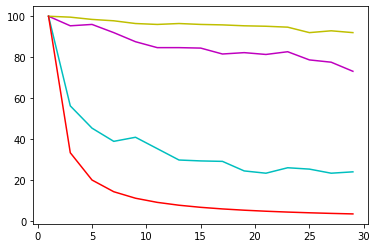

In [25]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

We tested with another architecture based on siamese model. We added 2 layers: 
- A convolutional layer with 128 filters 5*5
- A MaxPooling2D layer

In [26]:
def get_siamese_model2(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (5,5), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    
    
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

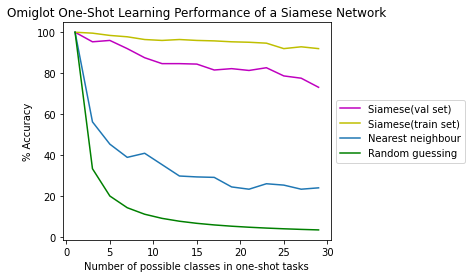

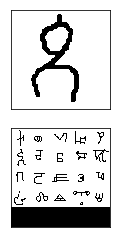

In [27]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20, "val")
plt.show()

plot_oneshot_task(inputs)

We see that the accuracy of siamese network is about 80 % on validation test, which is acceptable. In comparison with K-means and Random guessing, the siamese network is more effective. 